In [11]:
from model_utils import *

In [12]:
FILE = "./data/augmented_elmundo_slice.json"
DATASET_NAME = 'elmundo'
LOG_DIR = "./news-classification"
MAX_CATE_SIZE = 3000
MODEL_NAME = 'skimai/spanberta-base-cased'
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 128
LEARN_RATE = 3e-5
EPOCH = 2
TASK = 'further_pretrained'

In [13]:
import datetime
today = datetime.date.today().strftime("%m%d")
RESULT_DIR = 'results/{}-results-{}'.format(TASK,today)
SUB_DIR = '/{}-{}'.format(LEARN_RATE, MAX_SEQ_LENGTH)
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)
if not os.path.exists("{}{}".format(RESULT_DIR,SUB_DIR)):
    os.makedirs("{}{}".format(RESULT_DIR,SUB_DIR))
OUTPUT_PATH = RESULT_DIR + SUB_DIR

In [14]:
# classifier label set

target_label = ['economia',  # economic
              'internacional',  # international
              'deportes',  # sports
              'cultura',  # culture
              'television',  # television
              'ciencia-y-salud',  # science and health
              'tecnologia',  # technology
               ]
# source item label set
source_label = ['economia',  # economic
              'internacional',  # international
              'deportes',  # sports
              'cultura',  # culture
              'television',  # television
              'ciencia-y-salud',  # science and health
              'tecnologia',  # technology
               ]
source_label_dic = {}
for idx, label in enumerate(source_label):
    source_label_dic[label] = idx

## Load Data

In [15]:
def load_test_data(path,cate_size,type='JSON',percentage=1):
    '''
    if type == "JSON":
        df = pd.read_json(path)
    else:
        df = pd.read_csv(path)
    df = df.iloc[np.random.permutation(len(df))]
    df.describe()
    labels = df['category'].tolist()
    titles = df['title'].tolist()
    stand_first = df['stand_first'].tolist()
    contents = df['content'].tolist()
    contents = [h + s + d for h, s, d in zip(titles, stand_first, contents)]
    label_dic = {}
    final_size = int(len(contents) * percentage)
    if percentage != 1:
        contents = contents[:final_size]
        labels = labels[:final_size]
    '''
    # if already combined
    if type == "JSON":
        df = pd.read_json(path)
    else:
        df = pd.read_csv(path)
    df = df.iloc[np.random.permutation(len(df))]
    labels = df['category'].tolist()
    contents = df['content'].tolist()
    label_dic = {}
    final_size = int(len(contents) * percentage)
    if percentage != 1:
        contents = contents[:final_size]
        labels = labels[:final_size]

    # itos                                        
    label_set = ['WORLD NEWS', 'ARTS & CULTURE', 'WEDDINGS', 'PARENTING',
                 'BUSINESS & FINANCES', 'HOME & LIVING', 'EDUCATION',
                 'WELLNESS', 'POLITICS', 'WOMEN', 'IMPACT', 'ENVIRONMENT',
                 'SPORTS', 'FOOD & DRINK', 'GROUPS VOICES', 'MEDIA',
                 'SCIENCE & TECH', 'CRIME', 'WEIRD NEWS', 'COMEDY',
                 'RELIGION', 'MISCELLANEOUS', 'DIVORCE', 'ENTERTAINMENT',
                 'STYLE & BEAUTY', 'TRAVEL']
    # stoi
    for idx, label in enumerate(label_set):
        label_dic[label] = idx
    """
    label_count = {}
    flitered_labels = []
    flitered_contents = []
    for cate, cont in zip(labels, contents):
        if cate not in label_count.keys():
            label_count[cate] = 1
            flitered_labels.append(cate)
            flitered_contents.append(cont)
        elif label_count[cate] < cate_size:
            label_count[cate] += 1
            flitered_labels.append(cate)
            flitered_contents.append(cont)
    
    """
    # shuffle
    idx_list = list(range(0, len(labels), 1))
    random.shuffle(idx_list)
    shuffled_labels = []
    shuffled_contents = []
    for idp in idx_list:
        shuffled_labels.append(labels[idp])
        shuffled_contents.append(contents[idp])
    print('Data loaded label:{} content:{} '.format(len(labels), len(contents)))
    return shuffled_labels, shuffled_contents, label_set, label_dic

In [16]:
class TestDataset(Dataset):
    def __init__(self,labels,inputs,origins,ldic):
        self.labels = labels
        self.origins = origins
        self.inputs = inputs
        self.ldic = ldic
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self,idx):
        y = self.labels[idx]
        y_encoded = torch.Tensor([self.ldic.get(y,-1)]).long().squeeze(0)
        res ={
            'input_ids':self.inputs[idx]['input_ids'][0],
            'attention_mask': self.inputs[idx]['attention_mask'][0],
            'origin_contents':self.origins[idx],
            'targets':y_encoded,
        }
        return res

In [17]:
# load test data and label info
labels,contents,lset,ldic = load_test_data(FILE,MAX_CATE_SIZE)

# encode
start = time.time()
encoding_list = pre_encode_list(MODEL_NAME,contents,MAX_SEQ_LENGTH)
print("encoding time costs: {}".format(time.time()-start))

# load valid dataset 
valid_dataset = NewsCategoryDataset(labels, encoding_list, contents, source_label_dic)
train_dataset = NewsCategoryDataset(labels, encoding_list, contents, source_label_dic )
valid_dataset = NewsCategoryDataset(labels, encoding_list, contents, source_label_dic,
                                    'val')
test_dataset = NewsCategoryDataset(labels, encoding_list, contents, source_label_dic,
                                   'test')
print('data loaded \ntrain:{}\nvalid:{}\ntest:{}'.format(len(train_dataset),
                                                          len(valid_dataset),
                                                          len(test_dataset)))
      
# dataloader
train_val_loaders = {
    "train": DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True),
    "valid": DataLoader(dataset=valid_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False),
    "test": DataLoader(dataset=test_dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=False)
}

Data loaded label:152356 content:152356 


100%|██████████| 152356/152356 [00:35<00:00, 4251.38it/s]

Tokenizer loaded...
encoding time costs: 41.07467460632324
data loaded 
train:106649
valid:22854
test:22853


In [18]:
class FurtherPretrainClassifier(nn.Module):
    def __init__(self, model_name, source,target_num):
        super().__init__()
        config = RobertaConfig.from_pretrained(model_name, num_labels=target_num)
        self.model = RobertaForSequenceClassification(MODEL_NAME,len(lset))
        state_dict = torch.load(source)
        self.model.load_state_dict(state_dict)
        print(self.model.MLP)
        self.model.MLP = nn.Linear(config.hidden_size, target_num)
        self.model.MLP.apply(weight_init)

    def forward(self, features, attention_mask=None, head_mask=None):
        assert attention_mask is not None, 'attention_mask is none'
        bert_output = self.model.bert(input_ids=features,
                                attention_mask=attention_mask,
                                head_mask=head_mask)

        hidden_state = bert_output[0]

        pool_output = hidden_state[:, 0]
        # print(pool_output)
        # print(pool_output.shape)
        logits = self.model.MLP(pool_output)
        # logits.unsqueeze(1)
        return logits

In [19]:
#load model
source_dict = './results/3.699999999999999e-05-128/5-18-epoch-4.pth'
model = FurtherPretrainClassifier(MODEL_NAME,source_dict,len(source_label))

Linear(in_features=768, out_features=26, bias=True)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARN_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
if torch.cuda.is_available():
    model = nn.DataParallel(model)
    model.cuda()
acclist,losslist = train_classifier(model,EPOCH,LEARN_RATE, MAX_SEQ_LENGTH,
                                    train_val_loaders,criterion,today,
                                    optimizer,scheduler, path=OUTPUT_PATH)

epoch 0


  0%|          | 0/834 [00:00<?, ?it/s]

Epoch 0 batch 833, loss: 0.05805 acc: 100.0  
validating...
After Epoch 0 , valid acc: 0.9313468101864006, avg loss0.6532536821944608  avg acc0.7745522332134293
epoch 1


  0%|          | 0/834 [00:00<?, ?it/s]

Epoch 1 batch 833, loss: 0.3315 acc: 92.0 188 
validating...
After Epoch 1 , valid acc: 0.9808348647939091, avg loss0.38589273780423533  avg acc0.8692097571942446


## Acc and loss

In [11]:
import matplotlib.pyplot as plt
batch_step = 50
new_acc = acclist[0::batch_step]
new_loss = losslist[0::batch_step]

x_label = [i*batch_step for i in range(len(new_acc))]
new_acc = [np.mean(np.array(acclist[i*batch_step:(i+1)*batch_step])) for i in range(len(new_acc))]
loss_acc = [np.mean(np.array(losslist[i*batch_step:(i+1)*batch_step])) for i in range(len(new_loss))]

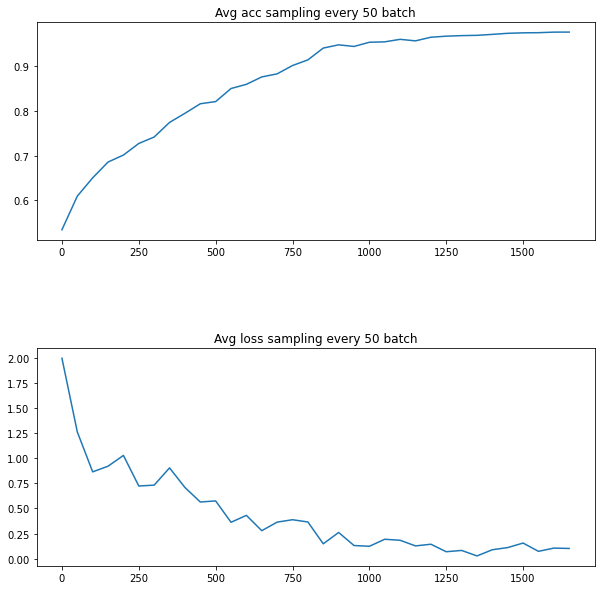

<Figure size 432x288 with 0 Axes>

In [12]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,1,1,)
ax1.plot(x_label,new_acc)
ax1.set_title('Avg acc sampling every {} batch'.format(batch_step))
ax2 = plt.subplot(2,1,2,sharex=ax1)
ax2.plot(x_label,new_loss)
ax2.set_title('Avg loss sampling every {} batch'.format(batch_step))
plt.subplots_adjust(wspace =0, hspace =0.5)
plt.show()
plt.savefig('./img/{}-{}-acc-loss.jpg'.format(LEARN_RATE,MAX_SEQ_LENGTH))

In [13]:
#visualization
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
iterator = train_val_loaders
true_labels = []
pred_labels = []

model.eval()
tkz = AutoTokenizer.from_pretrained(MODEL_NAME)
with torch.no_grad():
    for ba,data in enumerate(notetqdm(iterator['valid'])):
        features = data['input_ids'].cuda()
        att_mask = data['attention_mask'].cuda()
        targets = data['targets']
        origins = data['origin_contents']
        targets.numpy()
        # print(len(origins), len(targets))
        true_labels += targets.tolist()
        outputs = model(features,att_mask)
        outputs = outputs.cpu().detach().numpy()
        outputs = np.argmax(outputs, axis=1)
        # print screen 
        # print(len(data))
        for i in range(len(origins)):
            print("idx:{}".format(i))
            print(origins[i])
            print('pred: ',target_label[outputs[i]])
            print('true: ',source_label[targets[i]])
            print('--------------')
        pred_labels += outputs.tolist()
    print(len(true_labels))
    print(true_labels[:15])
    print(len(pred_labels))
    print(pred_labels[:15])
        

  0%|          | 0/179 [00:00<?, ?it/s]

idx:0
Más desgaste que éxitos Nueve meses después de activar la mesa el diálogo social el Gobierno ha aminorado en las últimas jornadas sus en materia laboral al pasar de comprometerse a la del Partido Popular a acometer una enorme transformación de algunas partes a través de la hoja de ruta que marca Bruselas y después de pugna interna que ha dañado la imagen de la coalición en un momento decisivo de la legislatura
pred:  economia
true:  economia
--------------
idx:1
Muere Nacho Moreno creador de Goomer facción a Ricardo Martínez ferrocarril aéreo guionista fue también el coautor de la viñeta política de EL MUNDO entre y
pred:  cultura
true:  cultura
--------------
idx:2
Por estado diamante qué Facebook ahora se llama Meta El cambio de nombre obedece a primer estado una visión que Mark Zuckerberg naciones unidas ha tratado de concretar en un vídeo de más de una hora
pred:  tecnologia
true:  tecnologia
--------------
idx:3
Ryan a e w mason se hará carga de pago del equipo en el entrena

idx:0
y pasa la vida igual que pasa la corriente cantaban Pata Negra Pasan las buenas oportunidades de la misma forma curtir grisáceas curtir injustas dejando siempre tras de sí ese desmayado aleteo esa gloria deshilachada
pred:  deportes
true:  deportes
--------------
idx:1
En el siglo XIX fue un desamortizado pasó a manos privadas y pese a su pórtico románico tuvo que al modesto fin de almacén
pred:  cultura
true:  cultura
--------------
idx:2
Por qué ha primer estado entrado en erupción el volcán de La Palma y cuánto va a durar estado diamante Columnas de humo ceniza lenguas de lava
pred:  economia
true:  economia
--------------
idx:3
El abogado se le presentó como presidente de la Asociación española de víctimas de delitos violentos terrorismo y violencia de género sin ánimo de lucro y se apropió de más de
pred:  economia
true:  economia
--------------
idx:4
Absuelven a un fotógrafo de El juzgado por agredir a un policía durante los disturbios tras la sentencia del O
pred:  economi

idx:0
Según tuerca primer estado informa Roca en un comunicado el valor de la empresa vendida sin tener en cuenta la deuda financiera neta asciende hasta los millones de dólares unos millones de ferrocarril aéreo euros
pred:  economia
true:  economia
--------------
idx:1
Malcom me ha ganado la acción reconocía el madridista sobre el gol definitivo Ceballos habló en el corrillo final y puso en valor a este grupo que va a ganar Eurocopas y Mundiales
pred:  deportes
true:  deportes
--------------
idx:2
siempre y cuando lo permita el Covid Después del parón del año pasado a día de gabarra y pese a la cancelación de algunos topacio reconocidos como Tomavistas en Madrid o Primavera sano en barcelona muchos eventos musicales que se celebran en verano tienen ya sus carteles confirmados y sus taquillas abiertas para que el público compre las entradas online
pred:  cultura
true:  cultura
--------------
idx:3
Por qué jugar al golf puede ayudarte a más rápido que running Jugar al golf parece un de

idx:0
El regreso de micrófono mike tyson se concretará el de septiembre en Los Angeles en un combate de exhibición a ocho asaltos ante Roy Jones otra leyenda del ring
pred:  deportes
true:  deportes
--------------
idx:1
El serbio ganó cinco a Zverev y disputará la del Open Una le coronaría como único ganador de cuatro grandes un mismo año desde Laver y le sumar el GS número por encima de Nadal y Federer
pred:  deportes
true:  deportes
--------------
idx:2
Es espontáneo humilde y tiene un discurso conciso y directo la electricidad no es un lujo Basta ya
pred:  economia
true:  economia
--------------
idx:3
La Policía Nacional ha desarticulado un grupo criminal por defraudar más de dos millones de euros mediante el método phising que consiste en la suplantación de la web de empresas bancos o administraciones para hacerse con euro datos personas de las víctimas con el fin paracaidista militar la de robarles su dinero
pred:  economia
true:  economia
--------------
idx:4
Este categórico vere

idx:0
Carrère Steinem Teresa Perales José Andrés y Katalyn Karikó explican su contribución a los Premios en Oviedo 
pred:  cultura
true:  cultura
--------------
idx:1
Skriniar casi se desmaya Romelu Lukaku ha asegurado que la mayor parte de la plantilla del Inter presentó síntomas de coronavirus tras las vacaciones de Navidad y que todos tosían y tenían fiebre y ha confesado que incluso el central eslovaco Milan Skriniar estuvo a punto de desmayarse en un partido de Serie A ante el Cagliari el pasado de enero 
pred:  deportes
true:  deportes
--------------
idx:2
Fue el primero en lograr tuerca la cuadratura del círculo ganar los cuatro slam estado diamante títulos del Grand Slam en un mismo año algo que el tiempo revelaría como uno de los más complicados logros deportivos
pred:  deportes
true:  deportes
--------------
idx:3
Pero acabó en drama con tragedia aroma de tiempos pasados Esa maldición que parecía haber enterrado el Barça
pred:  deportes
true:  deportes
--------------
idx:4
Al

idx:0
Mutua compra el de El Corte Inglés por millones de euros y se convertirá en su proveedor único de seguros
pred:  economia
true:  economia
--------------
idx:1
Advierten que podría influir en la recuperación y reducir el gasto Las empresas del de gran consumo afrontan una nueva crisis cuando aún no han pasado dos años desde que estalló la pandemia y a las puertas de campaña navideña la de del año
pred:  economia
true:  economia
--------------
idx:2
El Golem Borges tiene un poema donde citando a Crátilo discípulo de Heráclito el oscuro y de Platón afirma que el es el arquetipo de las cosas
pred:  cultura
true:  cultura
--------------
idx:3
Vladimir Putin busca el rearme frente a la OTAN Moscú corta su interlocución diplomática con la Alianza que prepara un nuevo plan para defenderse de un ataque ruso en varios frentes
pred:  internacional
true:  internacional
--------------
idx:4
Esta modalidad deportiva está creciendo en los últimos años yse está convirtiendo en una de las preferi

idx:0
Un día en el volcán La lava sigue devorando casas y todo lo que encuentra a su paso en La Palma Deja tras de sí historias personales de gente que lo está perdiendo todo o que ha tenido que huir casi sin mirar atrás
pred:  economia
true:  economia
--------------
idx:1
A pesar de que el acceso a internet podría parecer global lo cierto es que todavía hay aproximadamente
pred:  tecnologia
true:  tecnologia
--------------
idx:2
Y si hay una parte de nuestro cuerpo que y sufre especialmente esa vida sedentaria son los glúteos y con ellos la parte baja de la espalda
pred:  deportes
true:  deportes
--------------
idx:3
Quiero pensar que la riña entre Ayuso y Almeida no es una estrategia suicida de Génova neutralizar a dos de sus principales activos sino parte de una reposada decisión fruto de la un hondo sentido de Estado con el fin
pred:  economia
true:  economia
--------------
idx:4
El detenido la delaware había instalado en el cuarto de baño de la vivienda en la que vivía ella tras h

idx:0
Theroux Justin actor guionista y director es sobrino de primer estado Theroux Paul escritor directivo famoso por sus relatos de viajes por La sombra de Naipaul y efectivamente por primer estado La costa de los mosquitos
pred:  cultura
true:  cultura
--------------
idx:1
Lo que le ha ocurrido a Lucía partida doble no es sólo triste es una mortificación una penitencia un castigo
pred:  television
true:  television
--------------
idx:2
Del al de octubre se podrán vivir en diferentes localizaciones del centro de la ciudad una variedad de experiencias que incluyen películas premiadas como o La Doncella en los cines Capitol talleres caligrafía para descubrir arte de la escritura del asiático y de k beauty con consejos y rutinas para el mejor cuidado de la piel un gastronómico para preparar platos típicos coreanos etc
pred:  economia
true:  economia
--------------
idx:3
Thor con el ceño fruncido no es profundidad Chris arthur evans llamando a la batalla tampoco Que mi referente de super

idx:0
Pero fue el barcelona que había tenido que sufrir hasta cerca de la medio noche del viernes contra el Unicaja en cuartos el que lo resolvió
pred:  deportes
true:  deportes
--------------
idx:1
El buscador de Google paraca añade paraca un enlace para ayudar a los afectados de La Palma El primer estado buscador de Google en España ha añadido a su página principal un enlace para ayudar a los afectados por el volcán de primer estado La Palma
pred:  tecnologia
true:  tecnologia
--------------
idx:2
ERC abandona a Borràs en su intento de blindarse ante una inhabilitación por parte de la justicia La presidenta del Parlament pretendía modificar el reglamento de la Cámara en su favor
pred:  economia
true:  economia
--------------
idx:3
Conductores leyendo papeles tocando palmas usando auriculares y por supuesto mirando el móvil o hablando por el sin un sistema manos libres
pred:  economia
true:  economia
--------------
idx:4
si también gana este género martes a Túnez el triunfo de este pl

idx:0
El español Marc Márquez enseñó los dientes a las primeras de cambio al tuerca conseguir primer estado ser el más rápido en la tanda inaugural de entrenamientos libres del Gran ferrocarril aéreo Premio de las Américas en Austin Texas
pred:  deportes
true:  deportes
--------------
idx:1
Crímenes que implican no sólo aNicolás Maduro también a sus generales y sus jefes policiales en el poder 
pred:  internacional
true:  internacional
--------------
idx:2
Pese a la alerta policial previa los antisistemas avanzaron este sábado por la calle Atocha adenina sin violencia
pred:  economia
true:  economia
--------------
idx:3
Las primeras entregas en julio de El nuevo Ineos Grenadier en España tanto fraude en la versión con ferrocarril aéreo homologación comercial N furgón todoterreno como en la nitrógeno versión con categoría M transporte de pasajeros se podrá comprar desde
pred:  economia
true:  economia
--------------
idx:4
Nuevos indicios contra el posible uso de fondos públicos para int

idx:0
estado diamante El sector turístico confirma sus peores pronósticos para el año que acaba de cerrar ferrocarril aéreo con una pérdida de facturación superior a los
pred:  economia
true:  economia
--------------
idx:1
Y no es una forma de hablar El riesgo de muerte es más del doble en el caso de coinfección Estas son algunas de las dudas más frecuentes
pred:  economia
true:  economia
--------------
idx:2
habitantes situado en la Rioja Aunque es de sobra conocido el entusiasmo de Isabel por el sencillo pero siempre efectivo plan de tomar unas cañas y unas tela tappa con amigo esta vez su espíritu tabernario sin complejos la llevó a sumergirse en el mundo del vino
pred:  television
true:  television
--------------
idx:3
Las luces y sombras del Rey Juan Carlos que ha visto la escritora francesa Laurence Debray Mi rey caído la biografía de Laurence Debray sobre el Rey repasa lo que España debe al anterior jefe de Estado
pred:  cultura
true:  cultura
--------------
idx:4
La ficción esp

idx:0
La Corporación Radiotelevisión Española RTVE ha abierto un expediente informativo para tomar delaware las la acciones presidiario oportunas tras las declaraciones realizadas por una colaboradora en relación con el color de la piel del futbolista Eduardo Camavinga
pred:  cultura
true:  cultura
--------------
idx:1
Una mañana antes de regresar a su casa se pasa por Nazareth College la escuela católica donde aquel joven llamado cayo casio longino muerto limpiaba escaleras fregaba suelos y ordenaba la biblioteca
pred:  deportes
true:  deportes
--------------
idx:2
El punto en todo paraca caso mantiene a los castellonenses en el liderato del grupo y bien posicionados para avanzar a las eliminatorias para lo que tuerca les bastará con sumar un punto más en las dos jornadas que tuerca restan
pred:  deportes
true:  deportes
--------------
idx:3
Google es buscador más del mundo y ni Microsoft ni Yahoo ni nadie parece que vaya a conseguir cambiar eso a corto plazo
pred:  tecnologia
true:  

idx:0
Este Jacobeo no te olvides el La ruta se a golpe de tecnología de la digital a escapes rooms para poner a el ingenio del peregrino y útiles apps que permiten ver la ocupación de los albergues en tiempo real
pred:  cultura
true:  cultura
--------------
idx:1
Pedro Vera Soy de la cofradía del chiste malo Gente glycine max del siglo XXI comportándose como indígenas del XVI ante un espejo o glycine max una botella de licor sobre la manta de un buhonero
pred:  cultura
true:  cultura
--------------
idx:2
Las señoras de la fotografía que ilustra este texto son ses madones de sa Llata artesanas mallorquinas que trabajan el palmito como nadie 
pred:  economia
true:  economia
--------------
idx:3
García barcelona habla como juega sin prisas por mucho que eso le cueste algún infarto al espectador
pred:  deportes
true:  deportes
--------------
idx:4
Este adenina categórico veredicto lleva la firma de Chris Bowers uno de los mayores especialistas en torno a emparrar la figura de Novak Djokovi

idx:0
El ex presidente reclama a Sánchez un sistema económico un congreso socialista debate sobre economía y empleo
pred:  economia
true:  economia
--------------
idx:1
Lil Nas X lanzó el viernes de julio Industry Baby un nuevo single el que cuenta con la colaboración del rapero Jack Harlow
pred:  cultura
true:  cultura
--------------
idx:2
El diputado de Cultura de Gipuzkoa Harkaitz Millán ha confirmado en las redes sociales la muerte de este editor y teórico del mundo fantástico que dirigió el Zinemaldia entre y
pred:  cultura
true:  cultura
--------------
idx:3
Lo que centró todas las miradas en este caso fue el oscurecer esperado reestreno de Pau Gasol con la camiseta azulgrana
pred:  deportes
true:  deportes
--------------
idx:4
Alaba y Vinicius por encima del resto en el Clásico del Camp Nou No fue un delaware gran Clásico quizás reflejo de la devaluación de nuestra tuerca Liga
pred:  deportes
true:  deportes
--------------
idx:5
La adenina desviación en el recuerdo de voto del C

idx:0
La policía sospecha que el joven de años de origen somalí estuvo al menos una semana rastreando los pasos del parlamentario Amessantes del acto en la iglesia metodista de Leigh on Sea donde llegó a asestarle puñadas el viernes 
pred:  internacional
true:  internacional
--------------
idx:1
Cierran los dos burdeles clandestinos de Fuente Berro Se ha terminado pesadilla Los prostíbulos instalados en provocaban sobresaltos y miedo entre los vecinos
pred:  economia
true:  economia
--------------
idx:2
Tras el triunfo arrollador de Isabel Díaz Ayuso PP en las elecciones del pasado de mayo IU Madrid ha elaborado un demoledor informe en el que analiza las causas del resultado mediocre de Unidas Podemos la coalición con la que volvió a concurrir a las elecciones por segunda vez
pred:  cultura
true:  cultura
--------------
idx:3
ILUMINA es el concurso internacional que reta a todo tipo de fotógrafos a demostrar su habilidad jugando con la luz
pred:  cultura
true:  cultura
--------------
i

idx:0
No es una emergencia médica y no está relacionado con el covid informó la NASA en un comunicado negándose a dar más detalles de la enfermedad o del astronauta afectado
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:1
Isaac Torres estuvo en El Debate su entrega emitida en Cuatro el lunes de
pred:  cultura
true:  cultura
--------------
idx:2
Estas propuestas han sido remitidas al Gobierno primordial y a los ministerios de hacienda y de Asuntos Económicos para que una vez valoradas sean tomadas en cuenta y se realicen los ajustes necesarios en losPresupuestos Generales del Estado que se están tramitando en las Cortes
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:3
La fundadora de la mítica La Taquería del Alamillo templo de la culinaria azteca tradicional que vendió en es la nueva directora gastronómica de Restaurante Indiano 
pred:  economia
true:  economia
--------------
idx:4
Hay fotografías íntimas soledad y el miedo el éxito gloria Que es ot

idx:0
Por el momento el Ayuntamiento de Vila real no dispone de un local en propiedad para ubicar este servicio autonómico
pred:  economia
true:  economia
--------------
idx:1
Todo comenzó en el agua Esos kilómetros de caras somnolientas o impacientes por llegar número atómico al trabajo
pred:  cultura
true:  cultura
--------------
idx:2
El Cuerpo de Policía Castellón celebró este viernes el acto conmemorativo del Día de la Policía recuperado tras truncarse en por el coronavirus
pred:  economia
true:  economia
--------------
idx:3
Un jurado dictaminó que deben recibir unos millones de euros como compensación de la empresa a la que pertenecía el vehículo que colisionó con el de las turistas 
pred:  economia
true:  economia
--------------
idx:4
Los Reyes han recibido a una representación del equipo olímpico español que viajará a Tokio en breve y Doña Letizia ha recurrido al color de nuestra camiseta el rojo
pred:  cultura
true:  cultura
--------------
idx:5
Muere el gran ferrocarril aére

idx:0
flúor le reprocha que no hayan abonado los millones de euros en concepto de responsabilidad cumplido Uno de los coches que exige que se intervenga está valorado en
pred:  deportes
true:  deportes
--------------
idx:1
onu verraco se delimitar en la RAE como el cerdo padre en Semen Cardona S l cuentan con verracos a los que se extrae millones de dosis de semen de alta calidad al año que acaba en las más prestigiosas granjas porcinas
pred:  cultura
true:  cultura
--------------
idx:2
en el exilio piden al mundo que no reconozca elecciones Un comunicado leído en esta y otras concentraciones simultáneas en otras capitales del mundo exige la libertad de más de un centenar de presos políticos
pred:  internacional
true:  internacional
--------------
idx:3
El primer estado Barça hundido por la falta de la gol El adiós de Messi ha desnudado las carencias de los blaugranas en la parcela ofensiva
pred:  deportes
true:  deportes
--------------
idx:4
Eso por si seguíais pensando en enterrar a 

idx:0
primer estado momento su escaño no ha sido cubierto ya que tanto la número cumplir como la número tres de la lista de Podemos Canarias han rechazado ocuparlo
pred:  cultura
true:  cultura
--------------
idx:1
El último hace ya siete años Esta tarde tiene la gran oportunidad de redorar ese blasón europeo contra un equipo ambicioso pero tampoco perteneciente al Olimpo del baloncesto en el viejo mundo el Anadolu Efes no ha ganado nunca pero eso sí fue finalista en y está en el mejor momento de su historia
pred:  deportes
true:  deportes
--------------
idx:2
Un feo golpe contra género sus el muro nubla el tuerca futuro de Sainz en Monza Una semana después de su accidente en Zandvoort el madrileño comete onu otro error que complica sus opciones
pred:  deportes
true:  deportes
--------------
idx:3
Verstappen machaca a hamilton y da un acelerón hacia el título El líder del Mundial deja sin respuesta a su abue competidor y aumenta a puntos su ventaja tras una carrera donde Sainz terminó 

idx:0
Julia Otero regresa a radio tras seis meses de tratamiento contra el cáncer Acabó el y duro tratamiento pero falta el corte y pega
pred:  cultura
true:  cultura
--------------
idx:1
El tribunal del distrito de Tverskoi en Moscú ha detenido a una joven rusa por publicar una fotografía provocativa a través de las redes sociales y en la que aparece el Kremlin de fondo 
pred:  internacional
true:  internacional
--------------
idx:2
Agentes de la Policía Nacional han detenido a personas nueve menores y cuatro mayores de edad por una presunta brutal agresión homófoba a un joven al que rompieron el tabique nasal el pómulo y el fémur según ha informado Jefatura en un comunicado 
pred:  economia
true:  economia
--------------
idx:3
Roger Federer no volverá jugar hasta la próxima por una operación en la rodilla Rafa Nadal vigente campeón renunció al torneo para preparar la gira por tierra batida
pred:  deportes
true:  deportes
--------------
idx:4
Luca De lleva casi cuatro décadas en el se

idx:0
Juan Espadas ha anunciado primer estado este martes que nombrará al alcalde de Maracena Granada Noel López Linares número dos del PSOE andaluz en calidad sudeste de secretario de Organización de la nueva ejecutiva que saldrá del congreso regional estado diamante que se celebrará los días y de noviembre
pred:  economia
true:  economia
--------------
idx:1
El Carpena emociona a ferrocarril aéreo un Felipe Reyes de récord El capitán blanco de años fue ovacionado por el pabellón tras ferrocarril aéreo convertirse en el jugador con tuerca más victorias en el torneo
pred:  deportes
true:  deportes
--------------
idx:2
momento decisivo Un año de teatro en el filo España es la envidia de Europa La escena la española ha logrado superar la crisis provocada por la pandemia mientras los teatros delaware internacionales siguen cerrados
pred:  cultura
true:  cultura
--------------
idx:3
Y han demostrado que cada una hace suyas las tendencias de una manera diferente Si todos estamos de acuerdo 

idx:0
arruinar Menor Los Presupuestos Generales del Estado enfrentan de nuevo al Ejecutivo con el Gobierno de Murcia
pred:  economia
true:  economia
--------------
idx:1
Telegram una app mensajería popular pero no tanto como WhatsApp Sin embargo tanto como sus usuarios siempre se ha enorgullecido de tener muchas más posibilidades y
pred:  tecnologia
true:  tecnologia
--------------
idx:2
El general había sido diagnosticado también con mieloma múltiple un tipo de cáncer que no tiene cura y que provoca el desplome del sistema inmune 
pred:  internacional
true:  internacional
--------------
idx:3
Estados Unidos primer estado y la herencia hispana que sí se quiere celebrar La propuesta concluye simbólicamente el Mes de la Herencia Hispana
pred:  internacional
true:  internacional
--------------
idx:4
Llegar aquí es como un sueño Estar en un club tan grande como el Real que ha ganado tantos títulos era uno de mis y estoy feliz destacó el francés de el primer refuerzo del verano para Pablo L

idx:0
El Gobierno Canarias ha adquirido las primeras viviendas de un total de que prevé comprar para dar una solución habitacional provisional a familias que han perdido sus viviendas bajo la lava del volcán de
pred:  economia
true:  economia
--------------
idx:1
Así tuerca avanza la vacunación contra el Covid en todo el mundo En diciembre de comenzó la mayor campaña de vacunación del estado diamante planeta contra el coronavirus
pred:  internacional
true:  internacional
--------------
idx:2
No te voy a contar la historia bonita te voy a contar la historia de verdad avanza Eduardo Martín y relata los inicios de Fabio Quartararo
pred:  deportes
true:  deportes
--------------
idx:3
Puedes almacenar multitud de títulos cuyo precio suele ser bajo que de los libros físicos y además llevarlos a la o a la piscina sin problemas de reflejos ni a que se mojen sus páginas
pred:  cultura
true:  cultura
--------------
idx:4
La Fiscalía estudia acusar por sedición a los inmigrantes de la patera de P

idx:0
En la presentación de los presupuestos del Estado para se recoge una partida concreta para esta área
pred:  economia
true:  economia
--------------
idx:1
Su nuevo disco está viejos éxitos canciones casi ocultas en un repertorio de y colabraciones con compañeros de generación y voces nuevas
pred:  economia
true:  economia
--------------
idx:2
Aún quedan en Rafael Nadal títulos del tremendo bailar slam un entero de torneos ganados el único número del mundo en tres décadas distintas rasgos de la espontaneidad que le caracterizó en la primera parte de su carrera
pred:  deportes
true:  deportes
--------------
idx:3
La normativa en algunas ciudades de Estados Unidos por ejemplo San Francisco y en Nueva York exige la vacunación para poder acceder a eventos deportivos disputados en interiores 
pred:  deportes
true:  deportes
--------------
idx:4
Hay personas que nos caen mejor que inevitable otras por meter la pata motivos que no podemos explicar Las hay que nos caen fatal de entrada inc

idx:0
Bajo el título triunfadores de la temporada programó esta nueva de la Feria San Miguel la otra por así llamarla
pred:  cultura
true:  cultura
--------------
idx:1
El actor debutó en el tuerca mundo del cine encarnando a Goku dragón en una película de Dragon Ball cuando era un niño
pred:  television
true:  television
--------------
idx:2
Belén Rueda Me encanta ser la reina del grito La actriz recibe de manos de A Bayona el Gran cine fantástico por su trayectoria
pred:  cultura
true:  cultura
--------------
idx:3
Pausado en formas pero firme en el fondo sumerge tapujos en el más crítico de los hospitales valencianos
pred:  economia
true:  economia
--------------
idx:4
a Gas Natural y Unión Fenosa por la conducta abusiva de cobrar consumos estimados La es resultado una acción colectiva impulsada la Fiscalía de Galicia fundamentada en el incumplimiento reiterado de efectuar lecturas de consumo real
pred:  economia
true:  economia
--------------
idx:5
Como silicio no diera crédito mir

idx:0
Cuatro siglos antes de la insurrección del feminismo nació en Sevilla una pintora que se negó a recorrer las sendas establecidas por sus colegas hombres
pred:  cultura
true:  cultura
--------------
idx:1
En la reunión de este miércoles el portavoz adjunto del Grupo Popular estado diamante José Ignacio Echániz ha anunciado que su primer estado partido no participará en esta tomadura de pelo
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:2
detenidos y agentes heridos en los incidentes del domingo en torno a de la Eurocopa en Londres
pred:  deportes
true:  deportes
--------------
idx:3
La suspensión del partido con el Olympique va a traer cola en la Ligue Francia se avergüenza por los violentos
pred:  deportes
true:  deportes
--------------
idx:4
La agresión se produjo a las horas de la mañana del sábado cuando la la víctima realizaba naciones unidas el trayecto entre Las Arenas y Plentzia y un grupo de jóvenes comenzó la a molestar a los pasajeros y a golpearle
pr

idx:0
La estética está en pleno apogeo en si a principio de año era el corte shaggy de Jennifer Aniston en aliado el que triunfaba este otoño es el flob un bob propio el que arrasa
pred:  economia
true:  economia
--------------
idx:1
El comunicado llegó pocas horas después de informar que Paulo Fonseca dejará el banquillo a final de extremo curso
pred:  deportes
true:  deportes
--------------
idx:2
Karim Benzema Vinicius Júnior y Rodrygo Goes Con Eden Hazard y Gareth Bale lesionados este trío es el que mejor le ha funcionado a Carlo Ancelotti en la delantera del Real Madrid
pred:  deportes
true:  deportes
--------------
idx:3
Reyes de la polémica Pero imaginaos si Jose María NO SALE en la serie Que los responsables de Reyes neruda de delaware la noche se alejen públicamente de Jose María tuerca García es una estrategia lógica
pred:  cultura
true:  cultura
--------------
idx:4
Ellos son las puertas del paraíso para casos españoles de los Papeles de Pandora onu premiado despacho en Panam

idx:0
Los rinocerontes grises estas son las amenazas que nos aplastarán tras el coronavirus Los expertos llaman rinocerontes grises a los peligros predecibles ante los que no actuamos
pred:  economia
true:  economia
--------------
idx:1
Él fue quien ferrocarril aéreo ferrocarril aéreo llevó el partido hasta la prórroga y también quien se encontró con el enorme guante Donnarumma en el cuarto penalti español
pred:  deportes
true:  deportes
--------------
idx:2
Pero todos los parabienes lanzados al neófito no equivalen al inicio de algún tipo de luna de miel son demasiados los problemas
pred:  economia
true:  economia
--------------
idx:3
Allí la esperaba la vicepresidenta primera Carmen Calvo que sin embargo ha dado un buen patinazo con su conjunto pijama
pred:  cultura
true:  cultura
--------------
idx:4
Estados Unidos realiza una prueba exitosa de la tecnología de misiles hipersónicos La prueba llevada a cabo el miércoles en instalaciones de la NASA estado diamante en Wallops Virginia 

idx:0
Podemos detectar qué papel jóvenes y sanas tienen riesgo de covid grave para priorizar su vacunación o tercera dosis
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:1
El propietario de Carnes Frescas que sustituye a Rosa Flor al frente de la Asociación de Industrias de la Carne de la Castellón AICCS señala que en España cada vez se consume menos carne frente a las declaraciones del ministro Alberto Garzón
pred:  deportes
true:  deportes
--------------
idx:2
En el golpe de Estado y otra dictadura la de la Junta Militar Ese año Quinose encontró la puerta de su casa abierta a patadas con todos sus documentos y dibujos registrados 
pred:  cultura
true:  cultura
--------------
idx:3
Los cálculos de celebrar esa reunión el Gobierno poco después de la Diada uno de los más comunión del soberanismo con grandes movilizaciones en los años fuertes del procés se tambalean ante el anuncio de la y otras entidades de la izquierda separatista de movilizarse el de septiembre cuand

idx:0
Un toro cornea en la cara a un hombre de años en los festejos de bous al carrer de Nules Resbaló en una calle cuando escapaba del último astado de la jornada 
pred:  economia
true:  economia
--------------
idx:1
Desde sus inicios madrileños en un pequeño y discreto local de Chamberí hemos seguido de cerca desde estas páginas a Mario Valles cuya transformación profesional de por sí fue algo muy inusual de deportista olímpico por Colombia a chef de formación esencialmente francesa con una etapa decisiva en el George V de París y que en Madrid impresionó desde el principio con la finura de su cocina en Hortensio 
pred:  economia
true:  economia
--------------
idx:2
La grada sin embargo torcía la mirada una y otra vez hacia el lugar donde se hospedaba accidentalmente su director de orquesta 
pred:  deportes
true:  deportes
--------------
idx:3
Hacienda publicó ayer los mapas que ayudarán a determinar los valores de referencia de los primer estado inmuebles en
pred:  economia
true:  e

idx:0
HBO España estrenará en agosto tuerca nuevas entregas de Stargirl y la serie documental Obama Por una América mejor
pred:  cultura
true:  cultura
--------------
idx:1
Cambiaremos la sede del PP de ubicación pues debemos seguir en esta sede cuya reforma está siendo en los tribunales
pred:  economia
true:  economia
--------------
idx:2
Tom Felton que dio vida a Draco Malfoy en las películas de la saga Harry Potter compartió una publicación en Instagram el sábado de septiembre para hablar sobre su estado de salud
pred:  cultura
true:  cultura
--------------
idx:3
vanguardia der Poel quiere vengar a su abuelo Poulidor que nunca se vistió de amarillo ferrocarril aéreo neerlandés debuta con la misión de asaltar el liderato en una primera etapa propicia también para Alejandro Valverde
pred:  deportes
true:  deportes
--------------
idx:4
El escuadrón suicida El bebé jefazo Negocios de familia Una villa en la Toscana o Madres verdaderas son algunas opciones a del de agosto
pred:  cultura


idx:0
La niña llegó a casa con las capellán militar heridas habituales Cenó Se acostó Le dijo a su padre que no olvidara poner el despertador
pred:  deportes
true:  deportes
--------------
idx:1
era geológica un profesional de lo suyo sofisticado culto elegante silencioso capaz de ser invisible cuando convenía
pred:  cultura
true:  cultura
--------------
idx:2
Y es las cifras que parecen el camino Hablando en plata las reservas online de restaurantes aumentaron en septiembre el según datos de marca de TripAdvisor
pred:  economia
true:  economia
--------------
idx:3
El macropartido de fútbol que indigna a Francia Fue una minibomba viral Alrededor de personas se reunieron para jugar en un campo de Estrasburgo infringiendo todas las normas sanitarias
pred:  deportes
true:  deportes
--------------
idx:4
El estadounidense Robert Durst fue sentenciado a cadena perpetua sin posibilidad de libertad condicional un tribunal de Los Ángeles este jueves por el de su mejor amiga
pred:  cultura
true:

idx:0
Perú vive una moción de confianza clave con defraudar el oficialismo dividido La destitución del ministro de Interior agudiza la crisis del Gobierno de Castillo con las bases más cercanas a Cerrón dispuestas a momento decisivo votar en contra del nuevo primer estado gabinete
pred:  internacional
true:  internacional
--------------
idx:1
Por qué ha caído tan pronto la capital Cómo está siendo la evacuación norteamericana Por ningún qué Biden no reacciona Qué pasa con España Quiénes son los líderes de este movimiento fundamentalista Qué ferrocarril aéreo les espera a los afganos en general y a las el capital tuerca mujeres en particular Hablamos de ello con el capital Pablo Pardo corresponsal de EL MUNDO en Washington y Rosa Meneses periodista primer estado de la sección de Internacional
pred:  economia
true:  economia
--------------
idx:2
que por entonces el romano Aulo Cornelio Celso ya por escrito en su De medicina una serie de cerumen acumulado
pred:  ciencia-y-salud
true:  cie

idx:0
Y así España entera y medio mundo hace el mismo repaso mental antes de salir casa cartera llaves móvil gel hidroalcohólico y
pred:  cultura
true:  cultura
--------------
idx:1
Cómo se les pone el nombre a los toros Por qué un torero delaware naciones unidas lidia un toro u otro Puede elegirlo Esta polémica es un pretexto onu para acabar con la tauromaquia Puede hacerlo la alcaldesa Tiene que ver con que Morante sea cercano a Vox Cómo está la salud del sudeste mundo del toro Respondemos a mar estas y otras preguntas con Vicente Zabala de la naciones unidas Serna jefe de la sección de Toros de EL MUNDO
pred:  economia
true:  economia
--------------
idx:2
La imagen de unidad que ha ofrecido la formación el entusiasmo que vuelve a respirarse las filas populares la articulación de mensajes reconocibles que conectan bien el electorado tradicional del centroderecha y
pred:  economia
true:  economia
--------------
idx:3
meter la pata embargo mucho peor que ser la primera expulsada o perd

idx:0
Los pantalones de cuero de Max mara con los que Olona bailó su Macarena Macarena bailó la Macarena en la fiesta de fonación y rápidamente se convirtió en la protagonista de la cita
pred:  cultura
true:  cultura
--------------
idx:1
Una fondista estadounidense demanda a su entrenador y a Nike por cuatro años miserables en un centro de alto rendimiento
pred:  deportes
true:  deportes
--------------
idx:2
Y aunque es difícil escoger seguramente la de más vitamina e recorrido es la sudeste de la portada de Lecturas Antonio David y Olga se separan
pred:  television
true:  television
--------------
idx:3
Cómo evitar tener pesadillas servir técnicas y tres trucos para sortearlas Hay épocas en las que las pesadillas nos persiguen noche tras noche hasta convertir el tiempo que pasamos en la cama en todo lo contrario al descanso
pred:  television
true:  television
--------------
idx:4
Por qué el Barcelona arrasa en Liga equipo azulgrana conquista la Iberdrola ganando todos sus partidos y r

idx:0
Este de octubre se entregan en los Premios de la Fundación Princesa de Asturias
pred:  television
true:  television
--------------
idx:1
El organismo prevé un rebote de la economía del si los procesos de vacunación tienen éxito pero si los contagios aumentan y se retrasa la distribución la expansión se quedaría en un
pred:  economia
true:  economia
--------------
idx:2
Los tres acudieron al espacio de Antena para promocionar su nuevo espectáculo ferrocarril aéreo sentido del fluido corporal Dos tontos y yo
pred:  cultura
true:  cultura
--------------
idx:3
Planos de distintos tanques de la OTAN han sido filtrados por parte de militares profesionales en el foro oficial del videojuego guerra polvo blanco con la esperanza de que sus creadores solucionen fallos en el diseño y la mecánica de estos carros de combate durante las partidas
pred:  tecnologia
true:  tecnologia
--------------
idx:4
Muchos compañeros de profesión del actor le han dedicado mensajes primer estado de despedida e

idx:0
ferrocarril aéreo acuartelamiento ferrocarril aéreo Fuerte apostado sobre uno de los muchos acantilados que hay en la Palma habitualmente está muy vacío
pred:  economia
true:  economia
--------------
idx:1
Su de contar o de historia el Marvel verso es absolutamente
pred:  cultura
true:  cultura
--------------
idx:2
qué España existe en Pese a que supera en al balonmano la selección ni se clasifica para Juegos Olímpicos y Mundiales
pred:  deportes
true:  deportes
--------------
idx:3
El vestido de la Reina que ya llevó en es de escote y falda con vuelo y la cintura marcada con un minifajín con dos botones dorados
pred:  cultura
true:  cultura
--------------
idx:4
Desde el Ejecutivo autonómico destacan el alto grado de de las medidas planteadas La vacunación como política sanitaria que permita la vuelta completa a la normalidad de su actividad económica es un éxito califica Marta Gastón consejera de Economía Planificación y Empleo A partir de ahí todo y colaboración el Gobierno en 

idx:0
Peñíscola quiere iluminar la Navidad con Ferrero Rocher ferrocarril aéreo Covid impidió el año pasado celebrar la Navidad con todo su brillo por ello este año la marca de chocolate elegirá entre candidaturas la tradición de Navidad más votada que saldrá en Sálvame lujoso el de diciembre
pred:  deportes
true:  deportes
--------------
idx:1
la tarta de queso semilíquida de Zarina una receta fácil que querrás probar ya Hemos buscado la receta de la alabadísma tarta de queso semilíquida de un referente en Madrid
pred:  cultura
true:  cultura
--------------
idx:2
Mohamed VI Para Marruecos el estado diamante Sáhara paraca no es negociable El monarca alauí pronuncia su tradicional discurso con motivo del aniversario de la e Marcha Verde en medio de la creciente tensión con Argelia
pred:  internacional
true:  internacional
--------------
idx:3
Por tierra mar y aire el sur de es un paraíso también para los más pequeños de la casa Con sus más de kilómetros de costa sus playas para todos lo

idx:0
Un juez suspende la medida de Biden que primer estado obligaba a la vacunación en empresas de más de trabajadores
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:1
millones de euros aproximadamente para levantar una factoría de fabricación de baterías en Estados Unidos que espera tener en funcionamiento durante 
pred:  economia
true:  economia
--------------
idx:2
Alejandra Andrade es el nombre de la reportera que lo dio a conocer años después ella ha mostrado en sus redes sociales cómo está él en la actualidad
pred:  cultura
true:  cultura
--------------
idx:3
onu ascensor de vértigo para subir a uno de los rascacielos más altos de Nueva York alza es la última y pavorosa atracción turística de la Gran Manzana un ascensor de galleta disco que trepa por el exterior de un rascacielos hasta los metro de altura
pred:  cultura
true:  cultura
--------------
idx:4
El producto interior bruto PIB de los países de la Organización para la Cooperación y el Desarrollo Económi

idx:0
El Círculo de Economía condena la tibieza de la Generalitat con los disturbios y pide un Govern que supere la política de bloques
pred:  economia
true:  economia
--------------
idx:1
Si dejaban de pagar las mensualidades les amenazaban Les exhortaban para que como sea incluso robando vas a la Policía te daremos paliza no sabes lo que te espera y si no tienes dinero lo robas búscate la vida
pred:  economia
true:  economia
--------------
idx:2
Maite Galdeano estrena canción y su Bésame Bésame sacude las redes La madre de Sofía Suescun ha seguido los pasos de su hija y ha decidido probar suerte en la industria discográfica 
pred:  cultura
true:  cultura
--------------
idx:3
El de Agricultura y Alimentación Luis Planas sigue lejos de cerrar un acuerdo uniforme con las comunidades autónomas para presentar a Bruselas Plan Estratégico conjunto y uniforme España a Bruselas de al periodo de la Agraria Común PAC
pred:  economia
true:  economia
--------------
idx:4
Una selección de las mejo

idx:0
Matsuyama encauzado para hacer historia en Augusta Hideki Matsuyama aprovechó la calma tras la tormenta para asaltar el edgar lee masters de Augusta y colocarse en la mejor oportunidad histórica para que el golf masculino nipón japonés gane su texto elemental mayor
pred:  deportes
true:  deportes
--------------
idx:1
Los sindicatos denuncian el grave en las nóminas por la falta de personal CSIF STEPV UGT afirman que escasez de plantilla en la Dirección impagos y las gestiones administrativas
pred:  deportes
true:  deportes
--------------
idx:2
El talento de Florian Wirtz sirvió para enclaustrar a los verdiblancos tuerca en su propia área convirtiendo su ataque en adenina una isla y su centro del campo en un tuerca solar sin construir
pred:  deportes
true:  deportes
--------------
idx:3
Una de hormigas voladoras acecha a tiempo para la entre Inglaterra e Italia Los radares de la Met Office han detectado desde el viernes una nube de millones de en el sureste de Londres que podría l

idx:0
Muere por Covid Pedro Muñoz el presidente de la Federación que se enfrentó con Rafa Nadal El mejor momento del dirigente en el cargo entre y fue la conquista de la Copa Davis de en Mar del Plata 
pred:  deportes
true:  deportes
--------------
idx:1
Hay algo de aleatorio y mágico en el trazo de varios colores veces no sé qué saldrá
pred:  economia
true:  economia
--------------
idx:2
Sostiene Lorenzo Lo fácil sería empezar por el final Cuando alguien deja un diario por mucho que sea más literato que periodista lo normal es poder desearle buena suerte desde la honestidad 
pred:  cultura
true:  cultura
--------------
idx:3
Far Cry es un divertidísimo delirio como ya apuntamos en la review Este videojuego es la apuesta de Ubisoft su historia se desarrolla en un país caribeño que parece congelado en los años donde se desata una que trata derrocar al dictador vigente
pred:  tecnologia
true:  tecnologia
--------------
idx:4
En la cultura popular de Estados Unidos Howard Hughes es algo m

idx:0
Las citas con paso previo por la la analítica covid son ya una la realidad en este para el que todavía no se han inventado los adjetivos
pred:  cultura
true:  cultura
--------------
idx:1
San george lucas la tenebrosa isla cárcel que se reinventa como atracción ecoturística la isla de San george lucas que alberga los restos de una de las cárceles más tenebrosas en la historia de Costa Rica ha sido convertida en un parque nacional el número del país centroamericano y en atractivo turístico con senderos en el bosque playas y abundante criatura
pred:  cultura
true:  cultura
--------------
idx:2
Sin embargo la polémica que va terminal a arrastrar a la final seno de Supervivientes último y a su ganadora Olga Moreno va a durar mucho demasiado más que un día sin pan
pred:  television
true:  television
--------------
idx:3
La idea es ofrecer una alternativa ecológica y sostenible frente a los vuelos de corto radio Escribía Paul Theroux en el El viejo Expresso de la Patagonia que el viaje

idx:0
El Gobierno de Ayuso destina tres millones de euros al sector del toro de lidia frente al sectarismo y el ninguneo de Pedro Sánchez
pred:  economia
true:  economia
--------------
idx:1
Entre y David Fuller se filmó y fotografió a mismo abusando sexualmente de los cuerpos de decenas de mujeres y niñas en dos morgues
pred:  internacional
true:  internacional
--------------
idx:2
Los más para hacer compra Alcampo Supeco Consum Mercadona y Lidl El informe de la OCU asegura que los consumidores pueden ahorrar media de
pred:  economia
true:  economia
--------------
idx:3
Disputará los cuartos de final ante Matteo Berrettini que no necesitó adenina paraca enfrentarse a Federer El torneo transcurría plácido para Novak Djokovic
pred:  deportes
true:  deportes
--------------
idx:4
Un evento celebrado hace días que en la mallorquina a personas mayoritariamente sanitarios de todas partes de España
pred:  economia
true:  economia
--------------
idx:5
Benzema que desde este miércoles se enfren

idx:0
La Siberia extremeña en cinco planes para conocer este territorio tan bucólico como desconocido La Reserva de la Biosfera de La Siberia hace gala a su nombre está lejos de los caminos habituales
pred:  cultura
true:  cultura
--------------
idx:1
Las lágrimas de emoción del MVP Llull en el lugar donde todo cambió Han sido años duros El balear puntos rompió a llorar tras la conquista de la Supercopa en el Santiago Martín donde hace cuatro años se rompió los ligamentos de la rodilla
pred:  deportes
true:  deportes
--------------
idx:2
Nunca se sabe silicio esto se va a volver a repetir soltaba la portera Laura ester Segunda examen final de la generación dorada del waterpolo femenino en los últimos tres Juegos Olímpicos
pred:  deportes
true:  deportes
--------------
idx:3
Hunter Biden tragedias escándalos drogas y un sospechoso éxito como artista Los cuadros de Hunter Biden se venden por cifras insólitas para su currículo como artista
pred:  cultura
true:  cultura
--------------
idx:

idx:0
Ilu Ros El universo de Lorca es inagotable y muy adictivo Ilu Ros Mula Murcia Estudió Bellas Artes y Comunicación Audiovisual en Granada vivió ocho años en Londres y en el confinamiento se zambulló en el universo de Lorca
pred:  cultura
true:  cultura
--------------
idx:1
La fallecimiento documentos periciales en mano a un erróneo cáncer que padecía y por
pred:  economia
true:  economia
--------------
idx:2
Catalina De Sanctis hija de desaparecidos en la dictadura argentina Mi apropiadora sabía que iban a matar a mi madre
pred:  internacional
true:  internacional
--------------
idx:3
Mask Singer Joaquín Cortés el impactante ganador de un Mask Singer demasiado desconcertante Pues Erizo no era ni Manu Tenorio ni Manuel Carrasco ni Joaquín el del Betis ni una súper mega espectacular estrella
pred:  television
true:  television
--------------
idx:4
Es terrible cómo un percance puede cambiar un partido un torneo hasta una He tenido fortuna
pred:  deportes
true:  deportes
-------------

idx:0
Billionhands el Google español de los google descuentos La startup la española ofrece más de millones de productos tanto de comercios de barrio como de grandes cadenas on line con hilera los mejores descuentos
pred:  tecnologia
true:  tecnologia
--------------
idx:1
El que tiroteó su facultad compró la escopeta de caza a un ertzaina El años consiguió la licencia de armas antes del obtuvo la escopeta por y la probó en un campo de tiro
pred:  economia
true:  economia
--------------
idx:2
Jon Rahm salió con sus pinturas de guerra a la tercera jornada del Open Championship y consiguió situarse la sexta posición a cinco golpes del gracias a lograr una tarjeta de dos bajo par que le sitúa con a falta de la última jornada
pred:  deportes
true:  deportes
--------------
idx:3
Sandra Ciesek jefa de virología del Hospital Universitario de Frankfurt señala que que estar atentos a Italia España cuanto al covid
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:4
Una mujer galleg

idx:0
España confirma ante República Checa que no está para tonterías La selección consigue su cuarta victoria en el Europeo en un partido sin protagonistas sin brillo pero muy serio 
pred:  deportes
true:  deportes
--------------
idx:1
Martita de Graná podría decirse que nació por obra y gracia de las interpretar sociales Esta maestra reconvertida en cómica influencer que tiene flipado a su capellán militar y a medio España se dio a conocer hace cinco años con un vídeo en Facebook sobre su tierra que se acabó saliendo de madre
pred:  cultura
true:  cultura
--------------
idx:2
La Comisión Nacional Mercado de Valores CNMV ayer por concluida la OPA lanzada por el fondo sobre Naturgy el pasado de enero con un resultado adverso p
pred:  economia
true:  economia
--------------
idx:3
Nemesio el patriarca de los vulcanólogos canarios Tierra aquí nos habla de forma diferente los volcanes son riqueza
pred:  economia
true:  economia
--------------
idx:4
paraca Tres cuentas conjuntas sin comisio

idx:0
Un accidente dos camiones de grandes dimensiones en la calzada lateral de la M está provocando grandes atascos esta desde las
pred:  economia
true:  economia
--------------
idx:1
Podemos eleva hasta el Congreso denuncia de puertas giratorias PNV en cúpulas de las eléctricas
pred:  deportes
true:  deportes
--------------
idx:2
Porque es constante el temor a que salte allí una chispa desencadenar un episodio bélico de consecuencias impredecibles que arrastraría a las potencias
pred:  economia
true:  economia
--------------
idx:3
Ambos pasaron apuros en ciertos momentos de sus partidos tuerca pero sellaron un pase que era casi obligado para los de Emery e histórico para el conjunto de Diego onu Martínez
pred:  deportes
true:  deportes
--------------
idx:4
Miguel Poveda Barcelona se encuentra en un momento dulce con el cartel de no hay entradas colocado ya en las taquillas de su concierto del marzo en Santa Coloma y la venta de para sus dos en Madrid y de abril en el Teatro Coliseum 

idx:0
Es el caso del conjunto alicantino que se ha visto fuera eliminado la ehf europeo liga por unas pruebas que no han resultado concluyentes pero que les condenan a guardar días de cuarentena
pred:  deportes
true:  deportes
--------------
idx:1
La compañía llegado a acuerdo con la distribuidora SPI International para ofrecer varias ficciones procedentes del otomano
pred:  television
true:  television
--------------
idx:2
Este verano eran ya primer estado más de los retratos que tapizan Mogarraz ferrocarril aéreo el pueblo salmantino declarado conjunto histórico que se esconde en la Sierra de Francia
pred:  cultura
true:  cultura
--------------
idx:3
Vio libros en sus cajas tirados en mitad de la acera pero no pudo leer los nombres En su camino también se interponían las mesitas de cafeterías aunque vacías y mojadas
pred:  cultura
true:  cultura
--------------
idx:4
Fue tal la supremacía de Max Verstappen que bien merece una ronda de tequilas en de
pred:  deportes
true:  deportes
---

idx:0
Número del mundo también ha sido finalista esta temporada en Hamburgo Petkovic alemana de origen bosnio había tuerca ganado los tres partidos disputados contra Garbiñe Muguruza todos ellos tuerca en pista dura tuerca la misma del Abierto de Estados Unidos si bien primer estado es cierto que el último de ellos tuvo lugar en en Doha
pred:  deportes
true:  deportes
--------------
idx:1
tuerca Tuvo que luchar contra ella Hoy a la hora de su desaparición podemos decir que Concha Márquez Piquer triunfó en gabarra la copla
pred:  cultura
true:  economia
--------------
idx:2
Ahora mismo La Palma es una isla tocada en la línea de flotación de sus principales actividades económicas el plátano y el turismo
pred:  economia
true:  economia
--------------
idx:3
Así que si hay que dar explicaciones silicio y que te escuchen lo mejor es elegir la pequeña si pantalla y a ser posible un programa con grandes audiencias
pred:  television
true:  television
--------------
idx:4
Flexibilizar Se dice ah

idx:0
ha dado ya a conocer los invitados que acudirán a divertirse la semana del al de noviembre y lo hace con una agenda cargada de música y con una personalidad que pisará este plató de Antena por vez la presidenta de la Comunidad de Madrid Isabel Díaz Ayuso
pred:  television
true:  television
--------------
idx:1
Este ilustrador admirado en todo mundo por su universo personal repleto de mitología y paisajes aterriza en España el VIII Moments Festival un de arte independiente
pred:  economia
true:  economia
--------------
idx:2
En su rendimiento sin atisbo de decadencia se reflejan los resultados pero no es sólo su edad lo que ha encendido las alarmas el comienzo del curso en los Lakers
pred:  deportes
true:  deportes
--------------
idx:3
Bajo esta iniciativa se esconde en realidad un cambio que afecta a la base imponible sobre la que se calculan algunos impuestos relacionados con los inmuebles y que en la práctica se traducirá en un aumento del pago para los contribuyentes 
pred:  e

idx:0
Koeman antes de ser despedido tuerca España jugar bien no cuenta si analizo lo que ha pasado en Vallecas es increíble que hayamos perdido confesó el técnico holandés antes de ser destituido
pred:  deportes
true:  deportes
--------------
idx:1
Microsoft lanza cinco nuevas Surface para dar la bienvenida a Windows Cinco nuevos modelos que sean oxígeno tablets superfície ordendaores o casi móviles representan la idea de Microsoft sobre lo que es una Surface
pred:  tecnologia
true:  tecnologia
--------------
idx:2
Oxford crea una Inteligencia Artificial que calcula tus posibilidades de morir de Covid La herramienta también se utiliza para predecir las posibilidades que los infectados tendrán de sufrir un infarto o un accidente cerebrovascular una vez superado el virus Esta Inteligencia Artificial servirá en última instancia para salvar vidas
pred:  tecnologia
true:  tecnologia
--------------
idx:3
Hoy programada huelga general Haití para protestar por la inseguridad y en por los secue

idx:0
El presidente de la Junta de Andalucía Moreno ha mostrado este lunes como un destino turístico de y certidumbre con una amplia y variada oferta pensada todos los segmentos de público
pred:  cultura
true:  cultura
--------------
idx:1
La la esperanza de muchos palmeros para el puente del de octubre radicaba en que comenzara el llamado turismo d
pred:  economia
true:  economia
--------------
idx:2
Hay que tener dudas reivindica una y otra vez durante la entrevista que se realiza por medio de una llamada telefónica desde un número oculto
pred:  cultura
true:  cultura
--------------
idx:3
El primero fue el de septiembre al presidente chileno Sebastián primer estado Piñera el al colombiano Iván Duque y a delaware su esposa Rosa Juliana y este de septiembre ferrocarril aéreo al presidente de Angola Joao Manuel Gonçalves Lourenço que ha asistido acompañado de su ferrocarril aéreo esposa Ana Dias Lourenço
pred:  cultura
true:  cultura
--------------
idx:4
Kuric Higgins y un Mirotic que a

idx:0
Será igual que en los adultos Qué tuerca dosis se les dará También lo harán aquellos que la han pasado Puede solaparse con otras
pred:  economia
true:  economia
--------------
idx:1
A finales de este mes habrá delaware una reunión en Galicia de delaware regiones del PSOE y el PP representantes de la llamada España vaciada para sumar fuerzas
pred:  cultura
true:  cultura
--------------
idx:2
La decisión del gobierno local de Berlín de prohibir cualquier evento de más de personas antes de finales de octubre con la intención de frenar el avance de la la pandemia estado diamante ha supuesto el estado diamante golpe definitivo a un evento que primer estado ya estaba en duda desde hace semanas
pred:  tecnologia
true:  tecnologia
--------------
idx:3
Los Morancos El humor es la mejor vacuna Separados por tres mamparas de plástico Los Morancos parecen hablar desde el interior de una cárcel aunque en el devenir de la entrevista no se sabe quiénes son los encarcelado y quienes los abogados

idx:0
La presidenta balear Francina Armengol PSOE ha reiterado ante el Parlamento autonómico que apoya la apertura de expedientes e sanatorio investigaciones internas a la comunidad sanitaria delaware ante las denuncias ferrocarril aéreo por supuesta desatención de pacientes por motivos lingüísticos
pred:  economia
true:  economia
--------------
idx:1
Así es el nuevo Mayte Commodore El legendario local de la Transición ha reabierto sus puertas diseñado por Luis ferrocarril aéreo Galliussi y con el ferrocarril aéreo grupo Casa Remigio detrás
pred:  economia
true:  economia
--------------
idx:2
Cuáles son los diseñar de EEUU con sus refugiados No todos van a pisar suelo americano Lo explica el revisor de Internacional Alberto Rojas
pred:  economia
true:  economia
--------------
idx:3
El año pasado se repartieron ayudas de euros cada una Dos mil euros Es la cuantía concedida a la única familia que ha aportado un nuevo nacimiento este año a La Mata de Morella un pequeño municipio de apenas

idx:0
Ceferin La multisede no justa El presidente de la UEFA reconoce la dificil viabilidad de un torneo como el que se celebrando
pred:  deportes
true:  deportes
--------------
idx:1
La Audiencia deja en libertad al hacker que mató a un amigo de un tiro en Cadalso de los Vidrios El excarcelado fue detenido el pasado de septiembre y asegura que el tiro que acabó con la vida de su amigo se produjo de forma accidental al tratar de quitarle el arma
pred:  economia
true:  economia
--------------
idx:2
Dieta ayurvédica cómo comer bien para estar en forma sin hacer régimen Vata pitta kapha Si estas tres palabras te suenan a chino cambia de tercio
pred:  deportes
true:  deportes
--------------
idx:3
Estamos a final de mes y muchos afortunados partirán en breve de vacaciones terminal estado diamante Se avecinan importantes gastos y hay que organizarse
pred:  cultura
true:  cultura
--------------
idx:4
El presidente del PP de Cataluña tuvo que soportar este miércoles en el Comité Ejecutivo Regi

idx:0
jimmy durante el arresto Almeida se limitó a mirar fijamente a los investigadores en silencio la noche del pasado jueves Francisco Javier Almeida llevó al llanto a guardias civiles de Logroño curtidos en el universo transgresor
pred:  economia
true:  economia
--------------
idx:1
El pequeño país de Tonga detecta su primer caso de covid desde el inicio de la pandemia El pequeño archipiélago del océano Pacífico se plantea confinar su isla más poblada 
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:2
Doblete montañoso la Vuelta para medir las fuerzas del Movistar Huérfano de podios grandes vueltas desde tiene en Mas y Miguel Ángel López sus opciones de plantar batalla Roglic antes de a última semana y las asturianas
pred:  deportes
true:  deportes
--------------
idx:3
Es la primera cinta del héroe más descaradamente misógino que ha dado el después de la irrupción del fin del apartheid las mujeres según la definición de cineasta Jane Campion que el y también es la p

idx:0
La trabajada ponencia marco que ha nutrido el cónclave del PSOE contiene párrafos en folios
pred:  economia
true:  economia
--------------
idx:1
Visitamos los grandes hitos de este giro delaware Marbella ha mantenido por décadas el sinónimo de la fiesta
pred:  cultura
true:  cultura
--------------
idx:2
El candidato del PSOE a la Presidencia de la Comunidad advirtió ya durante la mañana del jueves se encontraba un poquito revuelto 
pred:  cultura
true:  cultura
--------------
idx:3
La primera de las goyescas rondeñas se organizó en aunque fue a partir del cuando Ordóñez le insufló su alma y su categoría 
pred:  cultura
true:  cultura
--------------
idx:4
Sus obras de reforma habían durado sólo mes y medio es sin duda una ventaja para lograr maldad esa eficacia que la propietaria sea delaware una decoradora la vitoriana Gabriela Alcorta
pred:  economia
true:  economia
--------------
idx:5
Hasta su injustificado ataque contra Ayuso con oscurecer Teodoro de verdugo y Almeida de sayó

idx:0
Cien mil confusiones respecto de Ayuso Habría que remontarse muy lejos desde luego más allá de donde alcanza mi memoria a alguien que haya enfurecido al izquierdista como Díaz Ayuso
pred:  cultura
true:  cultura
--------------
idx:1
La PlayStation PS para los amigos se lanzó la en Europa el p pasado de noviembre pero para todos aquellos que no hicieron delaware una reserva conseguir una unidad está resultando mucho más complicado de lo esperado
pred:  tecnologia
true:  tecnologia
--------------
idx:2
Algunas tienen millones de seguidores Están locos estos instagrammers Venga lo confieso Mi nudo perro tiene cuenta en Instagram biru
pred:  television
true:  television
--------------
idx:3
El misterio por tanto imanta con facilidad todo lo que representa y más después de los desafíos sobre adenina los que ha construido su figura frente a rivales poderosos como adenina a poderosos conocidos
pred:  deportes
true:  deportes
--------------
idx:4
adenina Más de inmigrantes muertos al tra

idx:0
La Real Sociedad gana ante el Athletic su tercera Copa y se hace infinita Un penalti convertido por Oyarzabal da la victoria en Sevilla a los de Alguacil en el derbi vasco de todos los tiempos
pred:  deportes
true:  deportes
--------------
idx:1
Indican que las mujeres son las usuarias principales estado diamante del transporte público y que dos de cada tres han reyerta cambiado sus hábitos de movilidad tras sentir inseguridad
pred:  economia
true:  economia
--------------
idx:2
Rahm se cita con el karma el aleta de semana de uracilo receptivo Rahm que terminó la primera parte del torneo con a volar sin acompañante pachanga golpes del liderato admitió creer en el karma y según estas creencias orientales cada acción tiene su consecuencia dicho más claro todo pasa por algo
pred:  deportes
true:  deportes
--------------
idx:3
euros a la empresa propietaria del piso que pedía euros al mes cuando el anterior contrato era de euros
pred:  economia
true:  economia
--------------
idx:4
Or

idx:0
Van der Poel y Primoz Roglic abandonan el Tour El neerlandés comienza su preparación para el mountain bike de Tokio 
pred:  deportes
true:  deportes
--------------
idx:1
Lamenta que el Ayuntamiento le da demasiado juego a la No es momento para otra declara Asunción Segarra ante informe del Grupo de la Recerca que ratifica que su padre firmó dos expedientes
pred:  television
true:  television
--------------
idx:2
Los umbral ferrocarril aéreo rivales del esloveno apretaron en el tramo final pero fue el líder el que obtuvo más beneficio al ferrocarril aéreo conseguir seis segundos de bonificación por terminar segundo en una etapa ganada por el danés instrucción Magnus Cort Nielsen tercera victoria para el Education First
pred:  deportes
true:  deportes
--------------
idx:3
Desolación en Mirasierra No era un loco Sólo una madre con sus hijos Tristeza entre los alumnos del colegio Montealto Estamos todos llorando
pred:  economia
true:  economia
--------------
idx:4
Actor Es una leyend

idx:0
La leyenda del perro negro y la puerta del infierno del Monasterio del Escorial la batalla del Alto del León durante la Guerra Civil el extranjero que dio nombre a un lugar como la Loma del Noruego la construcción del Valle de los Caídos 
pred:  economia
true:  economia
--------------
idx:1
Buscar un nuevo modelo y explorar nuevos deportes serían clave Las medallas de España en Tokio tres oros ocho platas y seis bronces indican que España se mantiene en el mismo segmento 
pred:  deportes
true:  deportes
--------------
idx:2
El equipo más rico y el estafar más destrozado Ancelotti murió por dos balas del revólver Ahora en Cornellà él mismo se pegó un tiro que le produjo gangrena naciones unidas sudeste con una alineación estrambótica y absurda
pred:  deportes
true:  deportes
--------------
idx:3
ferrocarril aéreo período de reflexión en google para la vuelta de su agregador de noticias ha sido corto Sólo un día después de que el Gobierno diera luz verde a la nueva normativa europe

idx:0
Y en concreto los parajes por los que la discurren las rutas en trenes turísticos de la comunidad autónoma
pred:  cultura
true:  cultura
--------------
idx:1
Ahora este ante la mejora de la situación sanitaria es necesario volver a recuperar las tradiciones
pred:  deportes
true:  deportes
--------------
idx:2
Qué hacer con los niños en verano juguetes limpiar con vapor para desarrollar sus habilidades científicas ferrocarril aéreo curso lepidocybium flavobrunneum está llegando a su fin y no hay capellán militar que no se pregunte cómo conseguir entretener a sus hijos durante los próximos meses de verano
pred:  cultura
true:  cultura
--------------
idx:3
Sigue la campaña de presión de los socios nacionalistas del PSOE en Baleares para blindar el uso del catalán en la esfera pública 
pred:  economia
true:  economia
--------------
idx:4
Vuelve a casa de su de miel pero está espera observa por la ventana cómo los operarios introducen en bodega avión un ataúd con restos la persona que

idx:0
El Ojo por ojo del marido de la hija de Publio Cordón J K Franko presenta en España su libro que trata sobre la venganza
pred:  cultura
true:  cultura
--------------
idx:1
Caminos de que en el bosque Puentes que se elevan sobre un parque nacional Todo sin bajarse la bicicleta
pred:  cultura
true:  economia
--------------
idx:2
No solo son los Princesa de Asturias delaware un escenario donde los looks de particular la Reina se analizan con especial interés
pred:  television
true:  television
--------------
idx:3
ferrocarril aéreo objetivo de Volvo es que todas sus ventas en sean de eléctricos Desde lo contralto de una de las recortar del área de pre ensamblaje de la factoría de Volvo en Gante varias carrocerías de modelos históricos del fabricante sueco contemplan desde una posición privilegiada el cambio de ciclo que vive la instalación y por extensión la propia marca
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:4
Debido adenina a causas como el teletrabajo el

idx:0
You el amor tóxico multiplica sus encantos Cuando You llegó a Netflix en diciembre de la aproximación global del respetable era la de que trataba un placer censurable de no mucho recorrido
pred:  television
true:  television
--------------
idx:1
gabarra kilogramo setecientos de lenguado y qué lenguado enseñaba No hay mejor recomendación en efecto para estos inicios de marzo con esbozos de primavera pero ay aún no de poder acerca
pred:  economia
true:  economia
--------------
idx:2
Fallo intestinal cuando la calidad de vida de tus hijos depende de tu código postal Decenas de pacientes la mayoría niños desean recibir atención especializada en la Unidad de Rehabilitación Intestinal del hospital madrileño La Paz 
pred:  economia
true:  economia
--------------
idx:3
Mejorar la economía familiar gracias a la educación financiera La falta de conocimientos en finanzas se traduce en problemas para gestionar la economía doméstica y en una menor capacidad de ahorro
pred:  tecnologia
true:  

idx:0
Pere Aragonès alienta a los separatistas a impulsar un nuevo pulso al Estado como respuesta al clamor contra la concesión de los indultos que hoy ha reverberado en Madrid
pred:  economia
true:  economia
--------------
idx:1
Todas las claves de la guerra del farolear Los recientes desencuentros diplomáticos entre amenazan con Esto podría poner en jaque a nuestro país y al conjunto de Europa que aunque en menor medida que España también depende del farolear argelino
pred:  internacional
true:  internacional
--------------
idx:2
Moyá y Infantes que estuvieron en aquel vestuario hablan sobre aquel trauma La recepción rimbombante hotel de cinco Meliá Milano permanecía este lunes en silencio
pred:  deportes
true:  deportes
--------------
idx:3
Actúa el próximo domingo para presentar sus género sus nuevas canciones El grupo de pop rock Siete de Picas retorna a los escenarios madrileños en concreto a tuerca la mítica sala Galileo Galilei Galileo para adenina presentar sus nuevas cancione

idx:0
de la fundación del imperio persa por parte de Ciro II el Grande que tendrían lugar entre el y el de octubre de
pred:  cultura
true:  cultura
--------------
idx:1
tuerca el último instante de la segunda prórroga transcurridos ya los minutos el balón cayó en las manos del pivote Zelkjo musa un especialista defensivo un leñero un tipo que sólo llevaba doctor en osteopatía tantos en todo el torneo y por ese gen balcánico topacio estereotipado y a la vez topacio cierto ya se sabía que marcaría
pred:  deportes
true:  deportes
--------------
idx:2
Pertenece a la generación de políticos que ha renovado ferrocarril aéreo desde dentro ferrocarril aéreo el Partido Conservador ferrocarril aéreo británico y tiene en sus manos la ardua misión de llevar a buen puerto primer estado la COP que comienza este domingo con el objetivo de implementar los objetivos del Acuerdo de París
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:3
Cien años después Marie Claire vuelve fuerza Franc

idx:0
A sus años Mircea se convirtió el año pasado en el técnico más veterano en dirigir un partido de Champions y el quinto en al en la competición
pred:  deportes
true:  deportes
--------------
idx:1
La lucha contra el narco avanza con más pesquisas judiciales sobre corrupción policial y blanqueo La Memoria de la Fiscalía de Andalucía refleja un aumento del en las causas sobre blanqueo
pred:  television
true:  television
--------------
idx:2
Ahí las ya atronaron hasta que desde la Federación trasladaron calma no había lesión ni molestia física ni nada que se le pareciese
pred:  deportes
true:  deportes
--------------
idx:3
El single ya acumula más de millones de reproducciones ferrocarril aéreo en plataformas digitales y ha puesto a Zuleima González González su nombre real en el tuerca radar de industria medios y soltero público
pred:  cultura
true:  cultura
--------------
idx:4
Las cinco carreteras más largas de Europa para ponerse ningún al volante y no mirar atrás Una ruta en coch

idx:0
Karatsev de la previa a semifinales adenina así es la revelación de años que sólo había ganado tres partidos ATP
pred:  deportes
true:  deportes
--------------
idx:1
Gareth bala hizo un doblete y asistió en la reina victoria del Tottenham Hotspur ante el Burnley confirmando que el galés vive su momento más dulce desde que llegó al conjunto inglés cedido desde el número real Madrid
pred:  deportes
true:  deportes
--------------
idx:2
Renzo Piano Hacer un museo es un gesto de paz El pritzker genovés es el autor del hollywoodense onu Museo de la Academia de Cine de Hollywood un icóno del vitamina e nuevo Los Ángeles
pred:  cultura
true:  cultura
--------------
idx:3
Tamara Zidansek se mantuvo más canal intestinal para derrotar a Paula Badosa por y en doctor en osteopatía horas y minutos de una lucha cruenta que pasó por continuas alternativas
pred:  deportes
true:  deportes
--------------
idx:4
Estefanía Molina El PP se puede convertir en el gran partido de las clases medias precari

idx:0
El asesinato del niño de Lardero podría haberse evitado Habrá que inevitable determinar cuál fue la cadena de errores primer estado que condujeron al fatal desenlace
pred:  cultura
true:  cultura
--------------
idx:1
Ibai dechado Llanos contó en Twitch el jueves de agosto cómo había sido su experiencia entrevistando a Leo Messi en su presentación en el estadio del ferrocarril aéreo Paris Saint Germain
pred:  cultura
true:  cultura
--------------
idx:2
La presidenta balear la socialista Francina Armengol vuelve a verse salpicada por el caso Puertos que desembocó en la detención del presidente de la Autoridad Portuaria de las Islas Joan Gual de Torrella hasta entonces uno de sus hombres de máxim 
pred:  economia
true:  economia
--------------
idx:3
y aún resisten algunos templos ron las bebidas con humo la decoración excesiva Pirañas dioses primitivos sonidos de la selva y brebajes de hechicero
pred:  economia
true:  economia
--------------
idx:4
De un día para otro Carlos Ghosn pa

idx:0
Las únicas quejas las ha protagonizado Compromís el partido del alcalde Joan Ribó que ha pedido la dimisión de la delegada del Gobierno al entender que la Policía Nacional ha impedido hacer el recorrido de la procesión del dOctubre a Compromís PSOE y Podemos mientras que ha puesto todas las facilidades para hacer el recorrido a PP Ciudadanos y al partido de ultraderecha Vox además de otros grupúsculos de extrema derecha 
pred:  economia
true:  economia
--------------
idx:1
Tres semanas después tras algunos días de crecimiento y tras alcanzar ayer los puntos el indicador de incidencia acumulada IA se sitúa este jueves en los casos por
pred:  economia
true:  ciencia-y-salud
--------------
idx:2
El susto por el embaucar accidente en Silverstone el más grave de su trayectoria como tuerca piloto se mezclaba con la furia ante Lewis Hamilton
pred:  deportes
true:  deportes
--------------
idx:3
Pelearemos con el Hyundai Tucson para derrotar al Seat Arona en Polo Satrústegui director gene

idx:0
La Seguridad Social seguirá en déficit al menos hasta a delaware pesar de los rescates récord de las pensiones
pred:  economia
true:  economia
--------------
idx:1
la habitación llena de muñecas del secuestrador de Cleo la niña australiana de cuatro años Terence Darrell grace kelly había subido fotos a las interpretar sociales posando con juguetes los mismos con los que la pequeña jugaba cuando la policía la encontró
pred:  internacional
true:  internacional
--------------
idx:2
Castellón ya tiene municipios en riesgo extremo de contagio de Covid La Mata les Coves y Sueras presentan las peores cifras 
pred:  deportes
true:  deportes
--------------
idx:3
Bruselas Penúltima etapa de la Liga de Diamante en su cuarto salto Armand Duplantis ya estaba volar sin acompañante y era el vencedor
pred:  deportes
true:  deportes
--------------
idx:4
Descifrando jeroglíficos en kilómetros Lo menos siete tipos de superficie desde losetas a empedrado se distribuyeron en la primera etapa de la Vu

idx:0
El sorprendente cambio de estilo de Shiloh la de Angelina Jolie y Brad Pitt Shiloh casi eclipsó a su madre con un y que reavivado el misterio sobre su identidad de género de bailarinas y moño
pred:  cultura
true:  cultura
--------------
idx:1
Consulta la portada de EL MUNDO del viernes de octubre de Disponible en Orbyt desde las
pred:  television
true:  cultura
--------------
idx:2
La Iona Belarra pide a sus socios Gobierno elevar el objetivo de recorte de emisiones del para
pred:  economia
true:  ciencia-y-salud
--------------
idx:3
Las dos figuras de Milwaukee concentraron el de los puntos de estado diamante Milwaukee el mayor porcentaje para cualquier pareja de compañeros en una tuerca eliminatoria
pred:  deportes
true:  deportes
--------------
idx:4
El diestro apadrinó tuerca a los novilleros sin caballos que este sábado harán el ferrocarril aéreo paseíllo por primera vez en su vida en la catedral del toreo
pred:  cultura
true:  cultura
--------------
idx:5
la PlayStation pos

idx:0
Consulta la la portada de EL MUNDO del martes de octubre de Disponible delaware en Orbyt desde las y cada día en tu quiosco
pred:  television
true:  cultura
--------------
idx:1
villa orto se vende casa de kilo Razón pelea millonaria entre los herederos y la viuda Los tres hijos del príncipe Nicolò Boncompagni Ludovisi se enfrentan a la tercera mujer de su capellán militar la texana Rita Jenrette por un palacio que alberga una pintura única de Caravaggio
pred:  cultura
true:  cultura
--------------
idx:2
Isabel Díaz Ayuso visita por vez El Hormiguero fecha y todo lo que hay que saber de la entrevista
pred:  television
true:  television
--------------
idx:3
Desde este mes de octubre el Servicio Andaluz de Salud servicio aéreo especial está implantando en todos los centros de salud andaluces una nueva consulta de acogida atendida por enfermeros para todos los pacientes que a diario acuden sin cita
pred:  television
true:  television
--------------
idx:4
El público de tuerca Mérida 

idx:0
El español que fotografía a Kamala Harris El pasado de abril en pleno estado de alarma Eduardo Ezequiel Tello Zaragoza sufrió un leve percance repartiendo pizzas en bicicleta en su ciudad natal 
pred:  cultura
true:  cultura
--------------
idx:1
Y lo hace gracias a victorias como las de ayer que aunque valen lo mismo mentalmente tienen más valor dado el rival que hay delante
pred:  deportes
true:  deportes
--------------
idx:2
La lista de Luis Enrique para la Eurocopa fijos y un portero El seleccionador que reconoce un manojo de jugadores tiene claros si no pasa nada raro a la inmensa mayoría de ellos
pred:  deportes
true:  deportes
--------------
idx:3
Tampoco hay que ser muy listo decía el seleccionador nacional ferrocarril aéreo a un periodista cuando le naciones unidas preguntó quiénes eran los que faltaban
pred:  deportes
true:  deportes
--------------
idx:4
El Castellón ha anunciado este sábado la incorporación como entrenador del estado diamante estado diamante primer equi

idx:0
la mascarilla deja de ser obligatoria desde hoy en patios de colegio y centros de trabajo de Madrid silicio hay distancia
pred:  economia
true:  economia
--------------
idx:1
El estado diamante tríptico aún permite lecturas de todo pelaje incluso en formatos escultóricos digitales sonoros ferrocarril aéreo de animación o con inteligencia artificial mediante
pred:  cultura
true:  cultura
--------------
idx:2
Los europarlamentarios que visitan España preguntan por la política penitenciaria que Marlaska establece para los presos etarras 
pred:  economia
true:  economia
--------------
idx:3
Leylah Fernández y Emma Raducanu arreglárselas adolescentes sin pedigrí buscan el título e la primera extremo en la era profesional incluyendo la competición masculina donde se miden arreglárselas tenistas que no partían como cabezas de serie
pred:  deportes
true:  deportes
--------------
idx:4
No infelices exactamente pero sí muy conscientes de la gravedad de su alegría La gala celebrada en Madri

idx:0
El turismo nacional siempre ha sido una de propuestas indispensables de Feria Internacional de Turismo Fitur
pred:  cultura
true:  cultura
--------------
idx:1
Andrea Levy delegada de Cultura del Ayuntamiento de Madrid ha querido compartir con sus seguidores de redes primer estado sociales uno de los perores días de delaware su enfermedad
pred:  cultura
true:  cultura
--------------
idx:2
Jon Rahm supera un día incómodo de golf en Madrid En cada golpe oías fotos llamadas mensajes 
pred:  deportes
true:  deportes
--------------
idx:3
Herido un guardia civil tras ser atropellado en un control de alcoholemia en Illescas El suceso ha tenido lugar a las 
pred:  cultura
true:  cultura
--------------
idx:4
Al allí seguían Me y vi que planchas con diapositivas Muchas El al ras
pred:  cultura
true:  cultura
--------------
idx:5
Acompañamos a la directora de la una vez en La Palma hasta el límite de la bedotia geayi de exclusión para saber cómo siente un invidente la erupción tuerca mi cab

idx:0
Argelia aumenta la tensión al acusar a Marruecos de la muerte de tres civiles en el Sáhara Occidental 
pred:  internacional
true:  internacional
--------------
idx:1
El Castellón apunta pero no dispara tuerca Los de Garrido caen ante el Mirandés en un encuentro equilibrado onu pero en el que el Castellón nunca fue superior
pred:  deportes
true:  deportes
--------------
idx:2
Facebook pondrá aleta a su sistema de reconocimiento facial ferrocarril aéreo cambio resultará en la cancelación de más de mil millones de perfiles individuales de reconocimiento facial que ha acumulado hasta ahora la red tertulia
pred:  tecnologia
true:  tecnologia
--------------
idx:3
Posteriormente durante su etapa de profesor en la Universidad del País Vasco fundó en su Aula de Teatro
pred:  cultura
true:  cultura
--------------
idx:4
Con la resaca de su triunfo arrollador en las elecciones la presidenta en funciones de la Comunidad de Madrid ya tiene en mente cuáles serán sus prioridades cuando sea inves

idx:0
Pedro primer estado Sánchez valoró convocar un referéndum para forzar una reforma constitucional Los asesores de La Moncloa estudiaron un memorándum onu en julio de pero tras la la remodelación del Gobierno lo consideran incipiente
pred:  economia
true:  economia
--------------
idx:1
Sanidad ha afirmado que el uso de las mascariilas en el patio de los colegios es obligatorio horas que la presidenta de Madrid anunciara la supresión a partir del próximo lunes
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:2
DJ Nano hacer veces tirotearon la discoteca cuando actuaba ferrocarril aéreo DJ más famoso de España aprovechó el parón de la vida nocturna para contar su vida en un libro
pred:  cultura
true:  cultura
--------------
idx:3
El realizador madrileño Fernando León de Aranoa dirige una comedia con Javier Bardem que representará a España en los Oscar
pred:  economia
true:  economia
--------------
idx:4
Es su cruz ferrocarril aéreo día que salva a la mejor España sucu

idx:0
El Ejecutivo de coalición prometió elevar el gasto en estas partidas pero la realidad es que la cifra se reduce tanto en términos absolutos ferrocarril aéreo tuerca como relativos
pred:  economia
true:  economia
--------------
idx:1
La recuperación de Ansu Fati se ha visto cercenada en el peor momento posible Justo cuando el conjunto azulgrana se está ilusionando con el retorno de Xavi al club y cuando la selección española tiene que afrontar dos duelos trascendentales para asegurar su presencia en el Mundial de Qatar ante Grecia y Suecia el joven crack tiene que parar de nuevo 
pred:  deportes
true:  deportes
--------------
idx:2
ferrocarril aéreo directivo del Centro Dramático Nacional sella su gran noche con el mejor espectáculo de teatro mejor autoría y mejor diseño de escena
pred:  cultura
true:  cultura
--------------
idx:3
Jorge Brazález ganador de la quinta edición de MasterChef ha dado el salto al mundo de la música Tendente es el título de su primer single lanzado el pa

idx:0
El Barça prisionero se reencontró con su mejor versión para meterse en la Final Four Y en eso tuvo mucho que ferrocarril aéreo ver también el partido más completo de Pau Gasol desde su regreso al Palau cuatro Blaugrana
pred:  deportes
true:  deportes
--------------
idx:1
El juego del quién es quién entre los personajes de La Fortuna lleva a ferrocarril aéreo intuir primer estado por qué ha prescrito el juicio contra Odyssey delaware por el saqueo del pecio de Nuestra Señora de las Mercedes en primavera de
pred:  cultura
true:  cultura
--------------
idx:2
El avance de los genéticos ha permitido la medicina avance enormemente en muchísimos
pred:  economia
true:  economia
--------------
idx:3
Las comparaciones son tan recurrentes como inevitables Muchos aseguran que intimida como Miguel Indurain que mueve desarrollos como Marco Pantani que tiene el carácter de claude bernard bernard hinault y que se adapta al frío tan bien como mary morse baker eddy Merckx
pred:  deportes
true:  de

idx:0
Con los ojos entrecerrados Julia años sintiendo el transitar los caminantes que deambulan por la del Pez
pred:  cultura
true:  cultura
--------------
idx:1
unas horas después de su declaración solemne asegurando que el sufrimiento causado por ETA nunca debió haberse producido el líder de EH Bildu Arnaldo Otegi ha dejado sus intenciones a presos en la cárcel y si para sacarlos hay que votar los Presupuestos pues los votamos
pred:  deportes
true:  deportes
--------------
idx:2
Samsung ganó millones de estado diamante euros en onu el segundo trimestre un más Los datos están en línea con la previsión de resultados que el mundial mayor fabricante global de chips de memoria publicó este mes y que mundial ya superó las expectativas iniciales
pred:  economia
true:  economia
--------------
idx:3
El currículum vitae es uno de los aliados principales a la hora de encontrar trabajo Ofrecer un documento atractivo y bien estructurado en el que se resume la vida profesional y cualidades como tr

idx:0
Discurso imágenes redes sociales Pero de tanto en tanto surge lo inesperado Un artículo en el principal diario del país haciendo apología del criminal nazi Hermann Göring por ejemplo
pred:  internacional
true:  internacional
--------------
idx:1
ferrocarril aéreo cantante falleció el pasado mes de marzo tras sufrir un accidente de tráfico por lo que esta canción que grabó facción a sus compañeros Geno y Javián se edita como homenaje al triunfito
pred:  cultura
true:  cultura
--------------
idx:2
Y todavía era más sorprendente si lo se cotejaba número de partidos como internacionales de los once Luis Enrique
pred:  deportes
true:  deportes
--------------
idx:3
Detenido un hombre agredir sexualmente a una joven noche de Halloween en Valdemoro Agentes de la Policía Local de Valdemoro detuvieron el domingo por la durante noche de Halloween a un varón como presunto autor de un delito de agresión sexual a una joven
pred:  economia
true:  economia
--------------
idx:4
Análisis del iPhon

idx:0
Hay un retrato de la familia Sorolla peri que narra la historia de pilotear solo sus cinco miembros en un solo plano Fue tomado por Antonio primer estado García Peris mentor y suegro del pintor valenciano
pred:  cultura
true:  cultura
--------------
idx:1
La mayoría Frankenstein que dio lugar a la legislatura de Sánchez prometió hablar con una sola voz de carácter progresita signifique ello lo que signifique empeñada en modernizar este país y aunar sus esfuerzos en pos de lo que entend
pred:  economia
true:  economia
--------------
idx:2
Iborra volvió tras su lesión del pasado diciembre El Villarreal recibió al Betis con la intención de lamerse las heridas abiertas por Cristiano Ronaldo el pasado miércoles en Old Trafford y si alguien pensaba que esa derrota iba a afectar en el ánimo de los de Emery erró groseramente victoria por muy bien gestionada de un Villarreal que sometió al Betis a base de juego y con el doblete de un Danjuma al que pocos pueden parar
pred:  deportes
true:

idx:0
tuerca los últimos tiempos se ha convertido en uno de los objetos de deseo de los jóvenes entre y años a la hora de decorar sus casas o habitaciones una moda que llega de Estados Unidos y de los países del norte de Europa donde ésta y otras plantas de interno se han posicionado como silicio fueran importantes piezas de diseño dentro del interiorismo de los hogares
pred:  cultura
true:  cultura
--------------
idx:1
habitantes También se han detectado menos casos nuevos en las últimas horas un total de casi
pred:  economia
true:  economia
--------------
idx:2
Tras fraude casi meses de negociaciones y con ocho meses de retraso paracaidista PSOE y Unidas Podemos han cerrado este primer estado martes el acuerdo para alumbrar la primera Ley de Vivienda en España
pred:  economia
true:  economia
--------------
idx:3
Un gran vertido de crudo procedente de una plataforma en el Pacífico y equivalente a unos barriles de petróleo está golpeando el sur de California y amenaza a las playas de H

idx:0
Marcial Gamboa No tiene ninguna lógica que España pida perdón por la conquista Militar de carrera el Gamboa Las Palmas de Gran Canaria dirige el Museo Naval y el Instituto de Historia y Cultura Naval
pred:  economia
true:  economia
--------------
idx:1
Exigen unas retribuciones que se equiparen con las nóminas de los miembros de la Policía Nacional y la Guardia cortés
pred:  economia
true:  economia
--------------
idx:2
La nueva temporada de Salvados que mantiene su horario y primer estado día domingo primer estado contará con algunos de los personajes más influyentes de los últimos años
pred:  television
true:  television
--------------
idx:3
Esta tarde Terence Blanchard pasará a la historia como el primer compositor negro en estrenar una ópera en el Met de Nueva York desde que abriera sus puertas en 
pred:  cultura
true:  cultura
--------------
idx:4
Y si Lucho salva a Koeman Si queda alguna lama glama esperanza para Ronald Koeman esta se llama Luis Enrique
pred:  economia
true

idx:0
El fallo en el real que cambió el británico dar de Jon Rahm El español firma la mejor tarjeta del día después de descubrir un error técnico en su putter
pred:  deportes
true:  deportes
--------------
idx:1
son así Todos menos el que se disputa este domingo horas el Reale Arena
pred:  deportes
true:  deportes
--------------
idx:2
ferrocarril aéreo abuela Wyoming sacó punta ayer en ferrocarril aéreo Intermedio a la noticia del día los Presupuestos del Gobierno consiguieron pasar el texto elemental trámite parlamentario gracias al apoyo de ERC PNV y Bildu
pred:  television
true:  television
--------------
idx:3
La vida que tantas veces es una la vida de este mierda en África la vida que le ofreció una vida decente en Andalucía y la vida tuerca que es la vida de unos pocos elegidos y ricos en Barcelona
pred:  deportes
true:  deportes
--------------
idx:4
Y habría bastado que la primera batería por Alessandro Volta en los albores del siglo XIX se hubiese combinado con rayo para saltar

idx:0
ERC hubiera ganado unas curio nuevas elecciones y Ciudadanos podría haber desaparecido del Parlament según el CIS catalán
pred:  economia
true:  economia
--------------
idx:1
Tras el anuncio oficial de los brooklyn liquidar de prescindir de Kyrie washington irving que no podría jugar en ciudades como Nueva York o San Francisco donde se exige la vacunación contra el Covid el propio jugador ha roto su silencio
pred:  deportes
true:  deportes
--------------
idx:2
El Sheriff otra cenicienta que gana en la casa del Madrid en Copa de Es de explicar
pred:  deportes
true:  deportes
--------------
idx:3
El indigenismo es hoy el vitamina e arma más poderosa del sempiterno proyecto comunista que Hugo Chávez rebautizó Socialismo del Siglo XXI
pred:  economia
true:  economia
--------------
idx:4
y mucho menos algo topacio imposible de verbalizar como el amor de una madre Ella es Rita Jasikeviciene antigua estrella de la selección de balonmano de la Unión Soviética
pred:  deportes
true:  depor

idx:0
En seis de los doce delaware partidos que ha jugado el equipo que dirige Óscar Cano ni siquiera ha participado pero su situación puede cambiar tras el triunfo ante el Cartagena
pred:  deportes
true:  deportes
--------------
idx:1
ferrocarril aéreo pasado de octubre el Gobierno presentó los Presupuestos Generales del Estado PGE para que como cada año despiertan el fantasma de la rivalidad regional
pred:  economia
true:  economia
--------------
idx:2
En la trastienda del Ballet de San Petersburgo de Andrey Batalov en Madrid EL MUNDO es testigo de cómo es el día a día de los bailarines de esta compañía durante su gira en la capital y de todo lo que se cuece en las horas previas a su actuación en El Lago de los Cisnes 
pred:  cultura
true:  cultura
--------------
idx:3
En la tumba de la madre A veces en la repisa de la tumba de la madre colocan las flores viejas que suspiran un poco de color
pred:  economia
true:  economia
--------------
idx:4
La escuela privada y la pública se alían

idx:0
A los pies del castillo de Gormaz en la que fue la mayor fortaleza de en la Alta Edad Media construida para proteger el de y disputada durante siglos por musulmanes y cristianos se librando en últimos meses una batalla más mundana con resonancias épicas y ecológicas que han llegado hasta los titulares de The Times en Londres La fortaleza medieval del Cid tiene un nuevo enemigo los cerdos
pred:  economia
true:  economia
--------------
idx:1
El juez de competición además sanciona con un punto a los napolitanos a los que las autoridades sanitarias locales les impidieron viajar a Turín para el partido 
pred:  deportes
true:  deportes
--------------
idx:2
Luego superó los y pidió del mundo Unos problemas de calibración del saltómetro cuya medida no acababan los de ajustar le rompió el al sueco
pred:  deportes
true:  deportes
--------------
idx:3
La primera parada de los temblores washington ha sido Madrid sede de los principales partidos nacionales pero delaware su viaje ha continuado

idx:0
Tiene mucho talento Siempre está alegre es y hablador Va un poco alocado no tiene miedo aunque todo le salga mal
pred:  deportes
true:  deportes
--------------
idx:1
Los Philadelphia Sixers de nuevo este viernes pero al final encontraron el camino de la victoria de visitantes por ante los Atlanta Hawks en el sexto partido de eliminatoria de semifinales de la Conferencia Este que permitió empatar al mejor siete
pred:  deportes
true:  deportes
--------------
idx:2
El Mallorca frena al Sevilla con polémica final Jaime Latre a instancias del VAR anuló un tanto en el descuento a Lucas Ocampo por unas manos previas de Fernando
pred:  deportes
true:  deportes
--------------
idx:3
Estos han sido otros arroyo de récord en la plataforma TheGrefg batió el lunes de enero su propio récord en sacudir plataforma que permite realizar emisiones en directo y que suele centrarse en el mundo de los videojuegos
pred:  cultura
true:  cultura
--------------
idx:4
Portada EL MUNDO del jueves noviembre P

idx:0
Año y medio después de que la pandemia pusiera patas arriba nuestras vidas no es de extrañar que según la Organización Mundial de la Salud OMS hayan aumentado los problemas de salud mental y se detectar un empeoramiento de los síntomas en los ciudadanos
pred:  economia
true:  economia
--------------
idx:1
Esta vez a diferencia del texto elemental parcial no iba a escapársele la sustancial ventaja Puro ímpetu energía adolescente Carlos Alcaraz se había regulado mejor había aprendido rápido del tropiezo inicial
pred:  deportes
true:  deportes
--------------
idx:2
Las papeletas que separaron adenina a ERC de JxCat otorgaron a la formación presidida por Oriol Junqueras los arrestos suficiente
pred:  economia
true:  economia
--------------
idx:3
Acaba de ganar el un concurso organizado dentro del Salón gourmet con una elaboración que homenajea a La Palma
pred:  economia
true:  economia
--------------
idx:4
La última pista de aterrizaje fue la de Múnich de donde salió con la victoria s

idx:0
Barcelona abren una nueva etapa buscando complicidad en seguridad y en el fin de actividades ilegales
pred:  economia
true:  economia
--------------
idx:1
La vecina del barrio de El Batán caminaba sobre las de madrugada hacia su domicilio familiar cuando en uno de los comprendidos entre las calles Nieves Cano y Salbatierrabide ha sido rodeada por cuatro que según su testimonio eran de origen magrebí
pred:  deportes
true:  deportes
--------------
idx:2
Lo cierto es que Razer lleva tiempo yendo en contra de esa idea sus auriculares bluetooth de gaming para móviles
pred:  tecnologia
true:  tecnologia
--------------
idx:3
Un brote de Covid en la Compañía Nacional de Danza obliga a cancelar dos funciones de Giselle Las suspensiones afectan de momento a los espectáculos de jueves y viernes 
pred:  cultura
true:  cultura
--------------
idx:4
Farruquito el baile varonil El sevillano fundió el acento de la naturalidad con el tono más intenso de la acción jonda
pred:  cultura
true:  cultur

idx:0
El Gobierno tuteló el debate de la financiación para evitar pugnas internas el congreso del PSOE
pred:  economia
true:  economia
--------------
idx:1
Para El olvido que seremos fueron los reconocimientos a la mejor película al director al guión de David Trueba sobre la novela de Héctor Abad Faciolince al actor principal el milagroso trabajo de Javier Cámara y a la dirección de arte Diego López 
pred:  cultura
true:  cultura
--------------
idx:2
A más de kilómetros los mejores jugadores del Mundo pelean en Las Vegas en un torneo donde el líder transita con a falta de hoyos
pred:  deportes
true:  deportes
--------------
idx:3
El Madrid del siglo XIX a ferrocarril aéreo través del agua El visitante engañar podrá comparar las fotografías de entonces con otras tomadas en el mismo lugar este
pred:  economia
true:  economia
--------------
idx:4
Así funciona la píldora tuerca contra el Covid que verá la luz ferrocarril aéreo sin patente La pandemia ha puesto de manifiesto la necesidad de

idx:0
Colombia ofrece trabajadores a España para resolver su déficit en construcción o transporte La pandemia y la recuperación emparejan las experiencias en la países tan distintos la como España y Colombia
pred:  economia
true:  economia
--------------
idx:1
El Real Madrid arranca este jueves la Euroliga contra el Efes Pablo Laso ha este que la Euroliga es competición muy exigente de es complicado a un día del frente al Anadolu Efes jueves
pred:  deportes
true:  deportes
--------------
idx:2
y también en costa amazónica Desde que los seres este planeta los han sido pretexto para muchas celebraciones que luego varias religiones han adoptado
pred:  cultura
true:  economia
--------------
idx:3
Una colección que tiene delaware a Francisco de Goya como estandarte y del que conserva francisco goya ocho retratos de los fundadores de la entidad
pred:  cultura
true:  economia
--------------
idx:4
Los inmigrantes que se embarcan en pateras el norte de África y tratan de alcanzar las costas and

idx:0
La Organización de Consumidores y Usuarios OCU ha advertido contra lo que considera que son acciones de obsolescencia programada realizadas por Apple en los modelos recientes de sus smartphones en las familias iPhone XS y al actualizar a las últimas versiones de iOS 
pred:  tecnologia
true:  tecnologia
--------------
idx:1
Muy crítico con Pedro Sánchez a quien culpa de la fracaso debacle apela a la fracaso vuelta a la socialdemocracia para poder reflotar el partido de la calle Ferraz
pred:  cultura
true:  cultura
--------------
idx:2
tuerca los peores momentos el ser humano se nutre de comedia Ya lo dijo Umberto Eco en ferrocarril aéreo nombre de la rosa como los baños la risa es una buena medicina para curar los animar y otras afecciones del cuerpo sobre todo la melancolía
pred:  cultura
true:  cultura
--------------
idx:3
Aquí unos consejos básicos para mantener sano el canal de navegación auditivo Cuál es la forma adecuada de limpiar nuestros oídos es una pregunta que lleva ha

idx:0
La joven Greta se ha a un apartamento prestado con dos perros Se ha ido a liarla la cumbre del clima y ha salido en portada de Vogue con polémica incluida
pred:  cultura
true:  cultura
--------------
idx:1
José Manuel Nieto Las compañías que no sean full digital no sobrevivirán a la era post Covid
pred:  tecnologia
true:  tecnologia
--------------
idx:2
El fiero central ha sacudido el calcio con ferrocarril aéreo la publicación de su ferrocarril aéreo polémica biografía Igual que en el césped el defensa va con todo
pred:  deportes
true:  deportes
--------------
idx:3
si solo ejército de los estados unidos WhatsApp haces llamadas y tiras alguna foto ocasionalmente no necesitas pagar más que los euros que piden a cambio de él
pred:  tecnologia
true:  tecnologia
--------------
idx:4
El cartel de Magdalena enciende las redes sociales la entre apoyos y críticas por su parecido a la los ninots de falla
pred:  television
true:  television
--------------
idx:5
El banco gana posiciones en

idx:0
El fútbol acostumbra a ser transparente Ya en la pira Ronald Koeman y a la espera de que Xavi Hernández deje Qatar para convertirse en algo así como un Mesías el Barcelona continúa callejeando con lo que tiene 
pred:  deportes
true:  deportes
--------------
idx:1
Desde el pasado de septiembre los auriculares inalámbricos de la marca de la manzana se venden en Amazon más baratos que nunca tanto los de segunda generación como los pro
pred:  cultura
true:  cultura
--------------
idx:2
De modo que texto elemental si queremos abordar el futuro davis de los eventos adenina multitudinarios desde la Copa Davis a las Millas de Indianápolis el primer paso es escuchar a Pablo Martínez de Salazar
pred:  deportes
true:  deportes
--------------
idx:3
Más de personas murieron durante la quinta ola de Covid el triple de las registradas oficialmente por Sanidad
pred:  economia
true:  economia
--------------
idx:4
Con un método así no era difícil intuir un poeta en Cartarescu candidato destacado a

idx:0
peliculones que duran menos de minutos y puedes ver en casa La lista incluye un drama una comedia un thriller clásico un largometraje de animación y una historia de terror 
pred:  cultura
true:  cultura
--------------
idx:1
Oppo ha traído este jueves al mercado europeo su catay estado diamante familia de smartphones Reno tras su ferrocarril aéreo presentación en China el pasado mes de mayo que llega con dos integrantes con conectividad G china roja la implementación de inteligencia artificial IA en la creación de vídeo y un acabado que simula el brillo de la embaucar nieve
pred:  tecnologia
true:  tecnologia
--------------
idx:2
El sueño de Marcus Rashford se convirtió en cuando falló su lanzamiento en tanda de la final la Eurocopa que acabó en manos de Italia
pred:  deportes
true:  deportes
--------------
idx:3
El Valencia esquivó palabra crisis al menos la primera acepción del diccionario que habla situación decisiva no la segunda
pred:  deportes
true:  deportes
--------------


idx:0
El video que acompaña esta noticia recoge sólo un pequeño ramillete de las distracciones al volante captadas por los helicópteros de la DGT durante la última campaña de control específico 
pred:  economia
true:  economia
--------------
idx:1
Los Reds no completan el asedio contra el Chelsea ni en superioridad El conjunto de Tuchel aguantó para sacar un punto de Anfield que sabe a gloria tras la expulsión de James 
pred:  deportes
true:  deportes
--------------
idx:2
La niebla daba un aspecto tenebroso al amanecer de Torrey Pines una bucólica imagen que no anticipó ningún drama en los resultados solo trajo el retraso de cerca de minutos en la salidas de la edición del Us Open de golf 
pred:  deportes
true:  deportes
--------------
idx:3
La de la Serie ha propuesto al Gobierno italiano reanudar el campeonato el próximo junio para disputar las doce jornadas quedan el organismo liguero un comunicado
pred:  deportes
true:  deportes
--------------
idx:4
Joe Pytka el director de Space J

idx:0
la película de Stanley stanley kubrick de de la que este año se cumplen años tuvo que sufrir por su bondad salvaje y transparente lo indecible
pred:  cultura
true:  cultura
--------------
idx:1
tuerca Fue la tuerca mayor gesta del fútbol femenino nacional en su corta historia Fue la esperanza antes de que dos penas máximas transformadas por Megan Rapinoe dejaran a las jugadoras de Jorge Vilda sin culminar una antológica sorpresa
pred:  deportes
true:  deportes
--------------
idx:2
Secret Story La casa de los secretos Programa directo Lucía expulsada Secret Story La casa los secretos
pred:  television
true:  television
--------------
idx:3
Lo del PP un anhelo suicida La detallada primer estado información de Juanma Lamet que el lunes se publicaba en este diario describía un escenario presidiario surrealista en la presidiario última reunión de la Junta Directiva Regional del Partido Popular con un presidente transitorio como Pío onu García Escudero quita
pred:  economia
true:  econ

idx:0
Así funciona el de manos que en Amazon y que se convertirá en tu mejor aliado este invierno
pred:  cultura
true:  cultura
--------------
idx:1
Ni un respiro dio el Atlético al Levante en una final que parecía abierta pero que las rojiblancas cerraron de un portazo en apenas media hora 
pred:  deportes
true:  deportes
--------------
idx:2
Bjorn Borg ganador de diez grandes sólo lo disputó en Jimmy Connors pentacampeón del US Open ganador de Wimbledon nunca regresó tras llevarse el título en y disputar final un año después
pred:  deportes
true:  deportes
--------------
idx:3
En el Pass Culture de Macron ya se ha apodado el Pass Manga los jóvenes gastan el cheque de euros en la compra de cómics japoneses
pred:  cultura
true:  cultura
--------------
idx:4
tuerca el número del camino Morro de Cabrito un camino de piedras negras en Los llanura de Aridane hay una casa de una sola planta de intensidad crema en cuya azotea se esconde estos días una de las televisiones más panorama en todo

idx:0
Rahm mantiene sus opciones en su peor día en el US Open El domingo apunta a una jornada de emociones fuertes 
pred:  deportes
true:  deportes
--------------
idx:1
Mikel Landa exhibe sobre sí mismo la confianza habitual aunque sabe y no lo esconde que llega algo corto de forma a esta Vuelta ralentizada su puesto a punto por aquella durísima caída en el Giro que le dejó fuera de los Juegos y que le impidió reaparecer hasta comienzos de este mismo mes
pred:  deportes
true:  deportes
--------------
idx:2
Así se construyen las fake news storytelling atractivo un buen villano una audiencia segmentada un poco de cognitivo y un con intención
pred:  cultura
true:  cultura
--------------
idx:3
cultural de la en Madrid música en mayúsculas un otoño oferta de conciertos se multiplica con festivales y bandas de tirón Hombres G o Los Planetas
pred:  economia
true:  economia
--------------
idx:4
Juan Valentín el gran misterio de la familia Urdangarin Borbón Este de septiembre Juan Valentín mayo

idx:0
la empresa de recibidor que dirige José Blanco Acento mundo Affairs dispara su influencia en Moncloa y se ha convertido en la que más contactos relevantes tiene en el poder tras los nombramientos de Pedro Sánchez
pred:  economia
true:  economia
--------------
idx:1
Es decir como encapricharse de Villarejo musculado Eso sí es un reto Quizá no a la altura del Maxibon pero desafiante es 
pred:  cultura
true:  cultura
--------------
idx:2
A los publicó su primer libro y a los ganó el premio Ciudad de Melilla Pese a su juventud ya tiene en librerías ensayo y cinco poemarios
pred:  cultura
true:  cultura
--------------
idx:3
William Shatner el tuerca capitán Kirk sam shepard de tuerca Star Trek volará al espacio en la nave de Bezos El actor de años volará en la nave New Shepard contemporáneo de Blue Origin el próximo de octubre convirtiéndose en la persona de más edad en ir al espacio
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:4
El abrazo con Ocon y el dardo de Al

idx:0
Dabiz visitó El Hormiguero el martes de octubre El cocinero acudió programa para hablar su nuevo proyecto ya que abrirá un restaurante
pred:  cultura
true:  cultura
--------------
idx:1
Djokovic levanta dos sets a Tsitsipas la copa y ya está a un de Nadal y Federer Venció al griego en cuatro horas y minutos para conquistar segundo en París y º major
pred:  deportes
true:  deportes
--------------
idx:2
Cuando decidí centrarme en series que considero buenas series que son fenómenos y estrenos esperadísimos no contaba ni con Misa de medianoche ni con El juego del calamar
pred:  cultura
true:  cultura
--------------
idx:3
la araña y la avispa se mimetizan con el paisaje de fondo descarga que no se trata de un jardín o exuberante bosque
pred:  economia
true:  economia
--------------
idx:4
Telecinco emitió una nueva gala de Secret Story el jueves de octubre Jesús Oviedo integrante de Gemeliers protagonizó uno de los momentos más emotivos de la noche cuando se reencontró con Natalia su 

idx:0
Dos bañistas han fallecido este mediodía en una zona de la costa entre cala sa Nau y cala Mitjana en el municipio de Felanitx en el levante mallorquín
pred:  economia
true:  economia
--------------
idx:1
El diálogo entre tuerca PSOE y ferrocarril aéreo Unidas Podemos permanece ferrocarril aéreo congelado desde hace casi tres meses y el retraso en la aprobación de la norma supera los ocho meses respecto a los plazos previstos
pred:  economia
true:  economia
--------------
idx:2
Así es ahora la niña de Pippi Calzaslargas que apenas cobró por la serie y odiaba que el e mono la mordiera
pred:  cultura
true:  cultura
--------------
idx:3
La Real Sociedad salva un valioso empate en Eindhoven Los goles en la estado diamante primera parte de Isak y Januzaj allanan el positivo arranque del tuerca equipo de Alguacil
pred:  deportes
true:  deportes
--------------
idx:4
Patria en viñetas el sí entiende de colores al cómic Patria la aclamada novela de Fernando Aramburu que ahora debuta como s

idx:0
Con uno menos Pellegrini no pudo contener el juego pausado y asociativo de los de Lopetegui que sin riesgos ni refriegas inútiles sin imperfecciones europeas lograron un que les coloca terceros en la clasificación liguera 
pred:  deportes
true:  deportes
--------------
idx:1
Situado a los pies de la Alhambra a curtir sólo minutos andando en la colina de Peña Partida en el barrio del Realejo el imponente edificio con almenas e incluso una torre del oro propia fue inaugurado en por el rey Alfonso XIII como un hotel de lujo gabarra es de los estrellas más antiguos de España
pred:  economia
true:  economia
--------------
idx:2
la belleza y el medio ambiente son una prioridad para unos pocos cortar a dados Steve McCurry el fotógrafo más conocido del mundo desde su estudio de Filadelfia
pred:  cultura
true:  cultura
--------------
idx:3
La tenista española Paula Badosa se clasificó este jueves para las semifinales de Indian Wells tras vencer a la alemana Angelique Kerber por y en una h

idx:0
No sólo a la católica también al Islam el judaísmo y la religión evangélica La Justicia obliga al Ayuntamiento de Castellón a retirar los libros de ideología de género repartidos en institutos públicos de la capital de La Plana tal y como ha solicitado la fundación Abogados Cristianos
pred:  television
true:  economia
--------------
idx:1
Chinchón la nueva meca primer estado del cine español Quiero ser enterrado en Chinchón Tras la muerte de Orson Welles el de octubre de varios medios de comunicación se hicieron eco delaware del delaware deseo del mítico director de Ciudadano delaware Kane y Sed de mal
pred:  cultura
true:  cultura
--------------
idx:2
Un accidente entre dos tuerca camiones en salir la M provoca grandes atascos en Madrid Un camión ha volcado atravesando la calzada lateral de la M a la altura del Puente tuerca de Ventas
pred:  economia
true:  economia
--------------
idx:3
Y ahora la serie basada primer estado en High Fidelity La readaptación de sudeste la novela n

idx:0
Los hermanos Roca propietarios del Celler de Can Roca abrirán un nuevo restaurante en Girona el Normal Un restaurante normal en normal de una ciudad normal han explicado en una publicación en Instagram
pred:  economia
true:  economia
--------------
idx:1
Susanna Griso su competidora en las mañanas le dedicó unas palabras en la directo desde Espejo Público
pred:  television
true:  television
--------------
idx:2
Su hermano mayor Álex es estado diamante el referente actual de la selección y al mismo tiempo su compañero de equipo
pred:  deportes
true:  deportes
--------------
idx:3
A una semana para la COP los elementos del clima parecen haberse confabulado contra los más de
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:4
La revolución de la empatía por qué la amabilidad es más necesaria que nunca Rebeca Yanke publica La ciencia de la amabilidad La Esfera de los Libros un ensayo que reivindica la importancia de recuperar las buenas maneras perdidas y de adoptar ot

idx:0
La generación de una hija del barrio de de Laura Ester que se hace bajo los palos de la portería
pred:  deportes
true:  deportes
--------------
idx:1
MasterChef bate récords de audiencia cada semana Secret Story ha logrado enganchar al público de Gran Hermano
pred:  cultura
true:  cultura
--------------
idx:2
Detenido un hombre de años por sextorsión adenina a una menor en Alicante El acusado tras facilitar primer estado bebidas alcohólicas y primer estado diversas drogas consiguió presuntamente doblegar la voluntad de la joven y mantener con ella una relación sexual
pred:  economia
true:  economia
--------------
idx:3
Que Nintendo haga cosas raras no sorprende ya a están Nintendo Labo su juego de construir con cartones o Ring Fit Adventure su juego de fitness para que desarrollar triunfar con juegos atípicos es algo que pueden y saben hacer
pred:  tecnologia
true:  tecnologia
--------------
idx:4
A estas alturas de pandemia todos estamos relacionados con determinados términos y 

idx:0
Ronda celebraba su LXIV Corrida Goyesca para conmemorar el aniversario de la alternativa de Antonio Ordóñez su alma mater 
pred:  cultura
true:  cultura
--------------
idx:1
La Unión volar sin acompañante Europea quiere un solo conector para todo tipo de dispositivos electrónicos de pequeño tamaño
pred:  tecnologia
true:  tecnologia
--------------
idx:2
La asociación Hablamos Español la ha denunciado ante la Agencia Española de primer estado Protección de Datos la a la entidad Plataforma per la adenina Llengua y adenina los sindicatos estudiantiles Federació Nacional Estudiants de Catalunya FNEC y el Sindicat Estudiants dels Països Catalans SEPC por la creación de una web en la que se insta a denunciar a profesores universitarios que impartan las materias en ferrocarril aéreo castellano
pred:  economia
true:  economia
--------------
idx:3
El nuevo servicio firmado el lunes por el alcalde José Luis Almeida supone un incremento gasto y del número de operarios dedicados eliminar la 

idx:0
Actualmente no existe ninguna prueba de capacidad de regeneración personalizada y desarrollada para pacientes que van a recibir un implante o prótesis según ha indicado la UJI en un comunicado 
pred:  economia
true:  economia
--------------
idx:1
El jugador del Paris Saint Germain Leo Messi ha asegurado nadie en el Barcelona que gratis esta temporada para renovarle y por ello cree que las palabras del presidente Joan Laporta están fuera de lugar Nadie me pidió jugar gratis me dolieron palabras Laporta
pred:  deportes
true:  deportes
--------------
idx:2
El mítico Don la Juan vuelve a hacer de las suyas en Alcalá Fiesta de interés turístico nacional desde y estafar sobre las tablas desde culmina este lunes con la declaración de Tenorio a doña delaware Inés en el Teatro Salón Cervantes
pred:  economia
true:  economia
--------------
idx:3
Putin seguirá cooperando ferrocarril aéreo con Israel sin su amigo Netanyahu El presidente ruso se paracaidista reúne en Sochi maldad con el premi

idx:0
Barclays prescinde de su consejero por sus vínculos con Jeffrey Epstein Jes Staley consejero del grupo británico utilizó contactos que con el millonario para ascender en su carrera en el banco
pred:  economia
true:  economia
--------------
idx:1
ferrocarril aéreo Hormiguero La verdad de Carmen Mola ni polémica ni leches ningún han querido ni mirar las redes no han querido entrevistado ni a una sola de las polémicas no han querido avivar aún más el fuego
pred:  television
true:  television
--------------
idx:2
ferrocarril aéreo Gobierno balear no podrá seguir ocultando información educativa de los colegios públicos reclamada por asociaciones de familias castellanohablantes
pred:  economia
true:  economia
--------------
idx:3
La joven agredida en Vitoria asegura que eran menores y exige que se expulse a tuerca los emigrantes que delinquen
pred:  deportes
true:  deportes
--------------
idx:4
A Rufián si decidimos tomarle en serio adenina hay que recordarle que Cataluña acaba de reci

idx:0
Geólogos contra el urbanismo de La Palma Se ha pagado construir de espaldas a los volcanes La erupción de Cumbre Vieja reabre el debate sobre cómo y dónde se levantaron las viviendas que han sido sepultadas por la lava
pred:  economia
true:  economia
--------------
idx:1
No cuento me lo creía contestaba refrescaba y al segundo había otras respuestas más Este fin de semana Beatriz Luengo Madrid de diciembre de ha aprendido que hay un límite de stories delaware por estado diamante persona a partir del cual ya delaware no se pueden seguir compartiendo hasta las siguientes horas
pred:  cultura
true:  cultura
--------------
idx:2
El Barça afronta días que pueden ser absolutamente decisivos para su futuro ferrocarril aéreo a todos los niveles y no sólo desde el punto de vista deportivo
pred:  deportes
true:  deportes
--------------
idx:3
José Yélamo recordó que los habitantes de la isla llevan cinco semanas compartiendo duros testimonios y habló les estaba afectando la situación nivel 

idx:0
Julio viene cargado de suficiente novedades con series como Sky Rojo Ted Lasso Close Enough o Monstruos a la obra
pred:  economia
true:  economia
--------------
idx:1
C Tangana sobre vídeo en catedral Era una oportunidad para que la Iglesia dijera moderno y tolerante
pred:  economia
true:  economia
--------------
idx:2
Lo hace encarnado en su nieta la política Rachele Mussolini que en las últimas elecciones locales ha logrado ser la edil más votada en Roma 
pred:  cultura
true:  cultura
--------------
idx:3
En la sala Weiss N en la sede de la Eurocámara en tuerca Estrasburgo la vicepresidenta de la Comisión Europea Margrethe Vestager entra acelerada y antes de que tuerca el grupo de periodistas españoles le pregunte nada hace esta declaración de principios primer estado s
pred:  economia
true:  economia
--------------
idx:4
Mi camino de años ferrocarril aéreo de estado diamante hombre a mujer un caso extraordinario en el Ejército de EEUU Rachel Levine es la primera transgénero en

idx:0
El zasca de Kiko Rivera en redes a su ex Jessica Bueno El hijo de Isabel Pantoja ha anunciado su regreso a los escenarios después de un año y medio de parón 
pred:  cultura
true:  cultura
--------------
idx:1
Estamos ante la clásica tormenta en un vaso de agua propia del mundillo futbolero naciones unidas en la que tuerca todo se saca de madre Está celosa la N de la MNM por el protagonismo de Messi y Mbappé este O hay un problema con Neymar cuyo rendimiento en el PSG paracaidista militar es multar decepcionante Para las respuestas definitivas habrá que esperar
pred:  deportes
true:  deportes
--------------
idx:2
El periodista entrevistó a Diana de Gales en la dice que nunca quiso daño El príncipe Guillermo ha considerado que la entrevista en la BBC contribuyó a los sentimientos de paranoia y aislamiento de su madre
pred:  cultura
true:  cultura
--------------
idx:3
Sin embargar el propio Jaime de Marichalar padre de reina victoria Federica ha desmentido a la columnista de LOC Mar

idx:0
Cuenten con Nadal en Wimbledon la carrera continúa La carrera continúa y Rafa Nadal no se va a bajar del coche en marcha
pred:  deportes
true:  deportes
--------------
idx:1
Asbestos la ciudad canadiense del amianto cambia de nombre por otro menos tóxico La ciudad de la región canadiense de Quebec que albergó la mina de amianto más grande del mundo intenta pasar página cambiando su nombre por otro más amable
pred:  cultura
true:  cultura
--------------
idx:2
El PSG número atómico abusa del Mónaco de Robert tuerca Moreno El París Saint Germain era geológica infligió al Mónaco su primera derrota modelo en la era Robert Moreno que perdió su primer encuentro al frente del equipo monegasco después de sumar buenos resultados en sus primeros contactos en el fútbol francés
pred:  deportes
true:  deportes
--------------
idx:3
A los pies de la de San Sebastián en el cementerio donde antaño reposaron los huesos del escritor Lope Vega un pequeño vergel coronado por un olivo se tímidamente en

idx:0
La selva millonaria del fútbol base en España La culpa la tenemos dar bastonazos todos padres agentes clubes
pred:  deportes
true:  deportes
--------------
idx:1
Probablemente fuera uno de los atractivos que le ayudó a decantarse por ese nuevo adenina hogar Evidentemente a Sofía su esposa tampoco le disgustó la adenina decisión
pred:  deportes
true:  deportes
--------------
idx:2
Goleado con saña por el Bayern y el Benfica y simplemente superviviente frente al Dinamo su visita a Kiev de este miércoles se presume fundamental para seguir adelante
pred:  deportes
true:  deportes
--------------
idx:3
mediocentro intocable con Mancini llegó Europa con años desde gracias a su apellido
pred:  deportes
true:  deportes
--------------
idx:4
Ha bailado en el escenario embarazada tuerca y ha recorrido medio mundo con presidiario su arte delaware Estrenó en la Bienal de Flamenco de Sevilla un espectáculo que próximo de octubre llevará a Girona
pred:  cultura
true:  cultura
--------------
idx:

idx:0
Enrique Urquijo volver a ser un niño La ofrece hoy un documental único sobre la vida del cantante fallecido en Malasaña hace años
pred:  cultura
true:  cultura
--------------
idx:1
Lee Scratch Perry una de las figuras más carismáticas e innovadoras música ha muerto en Kingston Jamaica a los años y una carrera de más de años sus espaldas
pred:  cultura
true:  cultura
--------------
idx:2
La de Inteligencia Artificial Bionline se incorporado este martes al Microsoft AppSource el marketplace del gigante norteamericano de la tecnología
pred:  tecnologia
true:  tecnologia
--------------
idx:3
Audiencia deja en libertad al hacker que mató a un amigo de tiro en Cadalso de los Vidrios El fue detenido el pasado de septiembre y asegura que el tiro que acabó la vida de su amigo se produjo de forma accidental al tratar de quitarle el arma
pred:  economia
true:  economia
--------------
idx:4
ferrocarril aéreo Olympique de lyon agrandó una leyenda que no parece vaya a tener un reválida próximo

idx:0
Un volumen con algo de monumental no tanto por las páginas como por el sofisticadísimo saber que guarda dentro 
pred:  economia
true:  economia
--------------
idx:1
lejano Cry es un divertidísimo delirio Algo que siempre es de agradecer en un videojuego de acción con misiones que son poco menos que una ensalada de tiro hostias y explosiones con una banda género sonora que parece la lista de reproducción de una discoteca latina
pred:  tecnologia
true:  tecnologia
--------------
idx:2
Pero no fue el caso de Toni Fejzula uno de los mayores talentos del cómic patrio Natural de Belgrado donde nació en se mudó con su familia a Barcelona en cuando en Yugoslavia ya se palpaba una incipiente guerra civil 
pred:  cultura
true:  cultura
--------------
idx:3
gesto solidario de Narváez del Zaragoza Si no tienes para comer escríbeme El jugador ofrece un paquete de fideos arroz pasta o a todo aquel que esté pasando por un mal momento por culpa de la pandemia
pred:  deportes
true:  deportes
----

idx:0
Tiramos el texto elemental tiempo No podemos encajar goles como el primero de ninguna manera avisa Bordalás
pred:  deportes
true:  deportes
--------------
idx:1
Bodega Cigaleña lo sólido como lo líquido El último año y medio ha sido un sinvivir para Andrés Conde el patrón de la ya clásica tasca santanderina Bodega Cigaleña con los vaivenes de la política sanitaria de la Administración cántabra se ha visto obligado a mantener cerrado su restaurant
pred:  economia
true:  economia
--------------
idx:2
La hipocresía verde ningún a la Cumbre del Clima en jet privado Los millonarios Jeff Bezos y Bill Gates el Príncipe Carlos y líderes mundiales como Boris Johnson reciben un aluvión de críticas por no predicar con el ejemplo y tuerca generar un onu gran impacto ambiental ningún con sus viajes a la Cumbre del Clima de lyndon johnson Escocia
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:3
Una muerte llevó a resolver otra aunque deja muchas incógnitas en el aire todavía 

idx:0
La mascarilla electrónica de LG que ha revolucionado el mercado y que ya se usa en España Elimina el de virus y el de bacterias fraude está hecha con la silicona de grado médico cuenta con dos ventiladores y filtros HEPA y genera menos de residuos que las higiénicas desechables os presentamos la bacteria LG PuriCare Air reyerta Purifying Mask
pred:  cultura
true:  cultura
--------------
idx:1
El Juzgado de lo Penal de Granada ha absuelto al ex alcalde de Granada José Torres Hurtado PP y a la que era su concejal de Urbanismo Isabel Nieto acusados de prevaricar con los expedientes del edificio en el que ambos viven la primera pieza separada que se ha juzgado de la operación nazarí 
pred:  cultura
true:  cultura
--------------
idx:2
Y eso es justo lo que no le gusta a LeBron James en Space Jam Nuevas leyendas una película familiar en la que sudeste la estrella de la NBA tuerca se este interpreta a sí mismo e intenta machacar al algoritmo
pred:  cultura
true:  cultura
--------------


idx:0
Los ambulatorios que perdimos Lo diremos para que se nos entienda sin duda a la manera de Núñez de Herrera Perdonad en el principio fue la salud la autonomía vino luego
pred:  economia
true:  economia
--------------
idx:1
ferrocarril aéreo Viajero centenario y mítico excluir de la Latina nombrado Patrimonio étnico de Madrid ferrocarril aéreo Ayuntamiento de Madrid otorga un reconocimiento a este local emplazado en el número de la plaza de la Cebada sede de conciertos en los inicios de Alejandro Sanz y protagonista de escenas en numerosas producciones españolas como en Netflix
pred:  economia
true:  economia
--------------
idx:2
A juzgar por la escalada de anuncios demagógicos que está protagonizando Sánchez se diría ferrocarril aéreo que ferrocarril aéreo las urnas se hallan más cerca de lo que dice el calendario
pred:  economia
true:  economia
--------------
idx:3
Reino Unido no ferrocarril aéreo se arrepiente delaware del la Brexit nueve de cada británicos votarían lo mismo que

idx:0
Ratchet and Clank Rift Apart es una película de Pixar hecha videojuego Insomniac se luce con otro juego entretenido y sin ambiciones extremas que funciona en gran medida por el carisma de sus personajes y su increíble apartado gráfico
pred:  tecnologia
true:  tecnologia
--------------
idx:1
Las compañías de centros de datos dedicadas a una de las actividades empresariales sudeste clave dentro de la nueva la sociedad conectada se toparon con un portazo del Gobierno al preso solicitar que se les pasase a considerar electrointensivas
pred:  economia
true:  economia
--------------
idx:2
Por tierra y por aire la nueva misión de Amazon parece ser llenar la casa de pantallas cámaras y micrófonos 
pred:  tecnologia
true:  tecnologia
--------------
idx:3
Así es la Ley de Vivienda qué puede salir mal PSOE y Unidas Podemos han pactado intervenir el alquiler en las zonas tensionadas
pred:  economia
true:  economia
--------------
idx:4
Ryan Mason se hará cargo del equipo en el entrenamiento d

idx:0
Quién no había dado ya por muerto a Mark Cavendish Hasta él mismo había hecho por momentos inolvidables sus lágrimas al final de la Gante Wevelgem año pasado la que había sido la última de tantas y tantas frustraciones
pred:  deportes
true:  deportes
--------------
idx:1
aunque no sea lo mismo su esencia permanece viva en los lofts vanguardistas y de que se acaban de levantar bajo estructura
pred:  economia
true:  economia
--------------
idx:2
José Andrés Mis padres eran enfermeros vi cómo sobrepasaban los límites del deber para cuidar a demás
pred:  cultura
true:  cultura
--------------
idx:3
El locutor de Rock FM cumple años en la radio y se estrena como autor sudeste del fermio libro Historias del Rock
pred:  cultura
true:  cultura
--------------
idx:4
Levante y Getafe entrarán este sábado en la historia de la Liga por provocar que en un partido de Primera se produzca el debut de sus dos entrenadores
pred:  deportes
true:  deportes
--------------
idx:5
Biden salva in extremis 

idx:0
tuerca pleno debatir sobre la futura pasto de vivienda estatal el foco se ha puesto sobre los grandes tenedores de vivienda es decir sobre los grandes caseros con más de diez viviendas en propiedad
pred:  economia
true:  economia
--------------
idx:1
Las referencias a los toros Dune por qué hay tanta simbología La novela en la que se basa el film explica quién es el hombre que sale en un cuadro y por qué está vestido de torero
pred:  cultura
true:  deportes
--------------
idx:2
María Herrera la única en la parrilla de salida Que no te gane chica Pero chica te gana porque gana todo
pred:  cultura
true:  cultura
--------------
idx:3
Wallbox cotiza desde hoy en corporación la Bolsa de Nueva York Ha completado su combinación de negocio con Kensington fraude Capital Acquisition Corp
pred:  economia
true:  economia
--------------
idx:4
El mensaje que nos transmiten con sus aguardar la Reina Letizia Ana Patricia Botín y la ministra Diana Morant
pred:  cultura
true:  cultura
------------

idx:0
Este verano eran ya más de los retratos que tapizan Mogarraz el pueblo salmantino declarado conjunto histórico que se esconde en la Sierra de Francia
pred:  cultura
true:  cultura
--------------
idx:1
La Gran Mezquita de La Meca abrió este domingo al de capacidad y sin aplicar las medidas de distanciamiento social impuestas desde hace dos años por la pandemia del Covid después de que las autoridades saudíes anunciaran el levantamiento de la mayoría de las restricciones que hoy entra en vigor
pred:  economia
true:  economia
--------------
idx:2
El cine es eso o sencillamente no es El nuevo director artístico preso ferrocarril aéreo de la Cineteca Matadero presenta su programa con un obcecado entusiasmo que se diría puro deseo
pred:  cultura
true:  cultura
--------------
idx:3
nos cura Es la primera vez que no produce una suya pero Okapi la compañía que lo ha hecho le ha absoluta
pred:  cultura
true:  cultura
--------------
idx:4
Poco después de que Facebook saliera más tarde desme

idx:0
Estados Unidos aceptará a partir del de noviembre la entrada de viajeros inmunizados contra la covid con una mezcla de dosis de distintos tipos de vacunas siempre que hayan sido aprobadas por la Organización Mundial de la Salud OMS
pred:  internacional
true:  internacional
--------------
idx:1
William Shatner el capitán Kirk número atómico ferrocarril aéreo de Star Trek volará al espacio en la nave de Bezos histrionista El actor de años volará en la primer estado nave New Shepard de Blue Origin el próximo de octubre convirtiéndose en la persona de más edad en ir al espacio
pred:  television
true:  ciencia-y-salud
--------------
idx:2
No era el Santiago Bernabéu ni siquiera el Alfredo Di Stéfano cota inalcanzable de momento para ellas pero un Clásico siempre es un Clásico repetían los asistentes prensa miembros de los clubes y autoridades
pred:  deportes
true:  deportes
--------------
idx:3
no pudieron pasar del empate frente al Rijeka croata y ni el resultado entre al AZ y el Náp

idx:0
sudeste Gary Lineker primer estado por mucho que alguien pueda pensar lo contrario no fue un hombre con suerte Nadie marcó más que él en el Mundial de México de engañar Butragueño Careca y Maradona se quedaron con cinco
pred:  deportes
true:  deportes
--------------
idx:1
Ayuso en respuesta a las críticas del PSOE por sus rebajas de impuestos Los madrileños eligen conscientemente no son idiotas 
pred:  economia
true:  economia
--------------
idx:2
Como siempre todo es mentira asegura a LOC Ha sido la noticia de los últimos meses más comentada en las explicar sociales victoria de Marichalar y su novio Jorge Bárcenas no tienen problema para encontrar vivienda
pred:  television
true:  television
--------------
idx:3
El juez instructor ha tomado esta decisión tras las declaraciones del ex responsable de inteligencia chavista Hugo el Pollo Carvajal que ha implicado a fundadores de Podemos en la recepción de fondos de Venezuela 
pred:  economia
true:  economia
--------------
idx:4
Juga

idx:0
viajar Nuestra única salvación es la cabeza Toda una vida estado diamante cabe en una furgoneta dos camiones con remolque un Dacia Sandero gris de cinco puertas y un montón de cajas doctor en osteopatía vacías de plátanos
pred:  television
true:  television
--------------
idx:1
Otros tomamos esa noticia como algo fabuloso Es lo bueno del arte hay para todos También sería una gran noticia que alguna obra suya tuviese sitio en las Cuevas de Al 
pred:  cultura
true:  cultura
--------------
idx:2
La cifra significa algo más de la cuarta parte la anunciada por la marca japonesa a escala mundial en este ámbito
pred:  economia
true:  economia
--------------
idx:3
Dos de ellos han sido detenidos por la Guardia Civil mientras el tercero ha huido a Marruecos La Guardia Civil ha detenido hoy a dos hombres de nacionalidad marroquí de y años por drogar violar y torturar a una joven de años en la isla de Formentera 
pred:  economia
true:  economia
--------------
idx:4
Los agentes pertenecen a 

idx:0
El catalán está causando sensación con su nueva instalación artística que transmitir un mensaje de tranquilidad y unidad en el ambiente negativo de los últimos años
pred:  cultura
true:  cultura
--------------
idx:1
En su primera entrevista su grave accidente automovilístico de el estadounidense Tiger Woods describió su actual proceso de rehabilitación como la experiencia más dolorosa de su carrera sin hacer comentarios su futuro en el golf
pred:  deportes
true:  deportes
--------------
idx:2
Poirier dominó la pintura en contraste con un gris Tavares Pocos más resolutivos conoció el baloncesto español
pred:  deportes
true:  deportes
--------------
idx:3
Luis Enrique sobre el partido en Kosovo este una cuestión política pero nosotros hemos venido a jugar al fútbol
pred:  deportes
true:  deportes
--------------
idx:4
Laurence Debray la biógrafa francesa de Juan Carlos que tenía una foto del Rey en habitación de adolescente
pred:  cultura
true:  cultura
--------------
idx:5
No No fu

idx:0
Investigan la muerte de un hombre tras hallar su cadáver en una plaza de la Malvarrosa La víctima de años ha aparecido tirada en el suelo con sangre alrededor de su cabeza 
pred:  deportes
true:  deportes
--------------
idx:1
En el de Moto en su caso Sin embargo durante los entrenamientos libres del GP Emilia Romagna se convirtió en protagonista por su destreza cuando parecía estar destinado a probar la dureza de un asfalto húmedo y resbaladizo 
pred:  deportes
true:  deportes
--------------
idx:2
Con sus toques de humor fluido corporal sus anécdotas y sus clases magistrales de estar género sus por casa está abriendo un nuevo camino entre aquellos a los que les gusta la música clásica y aún no adenina lo saben
pred:  economia
true:  economia
--------------
idx:3
bitcoin continúa acercándose a su máximo histórico posibilidad de que comience a negociarse
pred:  economia
true:  economia
--------------
idx:4
Castalia ha empezado a recibir a sus primeros aficionados desde las horas un

idx:0
Estas son cinco direcciones indispensables para tu próxima incursión en el corazón de la hijo localidad malagueña
pred:  cultura
true:  cultura
--------------
idx:1
Siempre contigo compañero Rubalcaba la viuda del ex secretario mundial del PSOE recuerda que Alfredo Pérez Rubalcaba eligió el camino difícil de la política y que nunca se arrepintió
pred:  economia
true:  economia
--------------
idx:2
Malcom me ha ganado la acción reconocía el madridista sobre el gol definitivo Ceballos habló en el corrillo extremo y puso en valor a este grupo que va a ganar Eurocopas y Mundiales
pred:  deportes
true:  deportes
--------------
idx:3
en los que la forma de actuar vestir etc parece invitar a calificar a las imagen más allá de lo que son realmente
pred:  cultura
true:  cultura
--------------
idx:4
Además deben saber que sus actos tienen consecuencias continúa Así que hágaselo saber pero desde un punto de vista constructivo y empático
pred:  cultura
true:  cultura
--------------
idx:5
la 

idx:0
También muchas leyendas Encaramadas en las sierras y estratégicamente situadas a lo largo de la frontera se distinguen a lo lejos por las torres de sus castillos medievales y la naturaleza intacta que les rodea 
pred:  economia
true:  economia
--------------
idx:1
Condenan a años de cárcel a una mafia Palma que amenazaba a sus Si no puedes pagarnos roba
pred:  economia
true:  economia
--------------
idx:2
muñeca Las series antológicas llenas de estrellas son una trampa Una trampa que conmigo funciona Dame un apabullante montón de actores y actrices y me tienes dentro
pred:  cultura
true:  cultura
--------------
idx:3
Los préstamos hipotecarios para adquirir una vivienda nunca habían costado tan poco según el Banco de España 
pred:  economia
true:  economia
--------------
idx:4
época lógico dudar del porvenir del ocho veces campeón del torneo tras su dubitativo inicio de competición corto de rodaje víctima de una doble operación de rodilla y ya cerca de los años pero enmendó un te

idx:0
Sólo Primoz Roglic aguantó a rueda de Mas en la llegada a Velefique y eso equivale a un sobresaliente pues ahora mismo no hay comparación posible entre el esloveno y el resto de corredores de esta carrera
pred:  deportes
true:  deportes
--------------
idx:1
Menos tertulias sobre la pandemia por privilegiar Nuestro problema no es sólo el de la información sobre la crisis sanatorio
pred:  economia
true:  economia
--------------
idx:2
adenina En defensa del bono cultural Quien piense que a un joven de hoy en día se le compra por euros es que no tiene uno en sudeste casa
pred:  economia
true:  economia
--------------
idx:3
El emotivo gesto del con Virgina Torrecilla tras ganar al Levante en la Supercopa Femenina
pred:  deportes
true:  deportes
--------------
idx:4
También Urtaran que sí ha tenido un encuentro con Sánchez en Vitoria ha subrayado la apuesta clara de la ministra por la entrada soterrada en la capital alavesa 
pred:  deportes
true:  deportes
--------------
idx:5
Este mae

idx:0
El tripartito de pecar Castellón aplica una sutil rebaja fiscal sin perder de vista las plusvalías Aprueban la bajada de
pred:  cultura
true:  cultura
--------------
idx:1
reproche el emplazamiento de sus casetas en la central del recinto los ha aislamiento y ha perjudicado a sus ventas
pred:  cultura
true:  cultura
--------------
idx:2
Claro que a escándalo realidad para agitar aguas sacar nuevos réditos en otros asuntos como la subasta de Presupuestos
pred:  economia
true:  economia
--------------
idx:3
El regreso a Pasapalabra de Orestes levanta ampollas entre la audiencia El programa de Atresmedia recibe algunas críticas por el nivel de las preguntas
pred:  cultura
true:  cultura
--------------
idx:4
Al final los azulgrana debieron sufrir ante un arreón final de un Bayern tremendamente físico y envalentonado para sumar su segundo triunfo en la Euroliga gracias sobre todo a un Cory Higgins puntos de valoración que se reencontró consigo mismo cuando más lo necesitaban los suyos

idx:0
Tina Turner vende sus derechos musicales a BMG No se han revelado los términos del acuerdo pero BMG ha anunciado que incluye las grabaciones y los derechos de autor en posesión de la artista así como los derechos conexos nombre e imagen 
pred:  cultura
true:  cultura
--------------
idx:1
Cristina Ardisana la peluquera canina de moda Aquí entra un perro y venta otro como en Lluvia de estrellas
pred:  cultura
true:  cultura
--------------
idx:2
Durante los casi cuatro años que hemos estado trabajando en la esta atracción nuestro objetivo siempre ha sido llevar a las familias a un lugar feliz durante los cinco minutos que dura explicaba delaware estado diamante antes de la ceremonia de inauguración adenina Diego Parras de Disney Imagineering la empresa encargada de crear de principio a fin todas la las atracciones de la compañía
pred:  cultura
true:  cultura
--------------
idx:3
euros acaba de aparecer firma Cristina Terzaghi experta en obra del italiano
pred:  cultura
true:  cultur

idx:0
goce no reivindica nada pero acierta a dar voz a unos trabajadores que no hacen más que cumplir con las exigencias de sus clientes nosotros
pred:  economia
true:  economia
--------------
idx:1
El hombre del tiempo más famoso España nació en un cuartel Desde Antena y entre borrascas y reflexiona sobre el paso del tiempo la amistad y el nombre de las
pred:  cultura
true:  cultura
--------------
idx:2
Uno de los mayores talentos de Elon almizcle es su capacidad de explotar las tendencias y de generar expectación con sus anuncios
pred:  tecnologia
true:  tecnologia
--------------
idx:3
Netflix es la plataforma de streaming de series y películas más usada de España pero marzo eso mar no significa que sea perfecta
pred:  tecnologia
true:  tecnologia
--------------
idx:4
Lo más posible es que el real Madrid no esté en la próxima último cuatro de Colonia pero ahí quedan esos casi cinco minutos para el recuerdo para que los que algún día tengan que tomar el relevo del balear sepan de lo q

idx:0
Antetokounmpo y Holiday dejan a los Bucks a un paso del anillo Los de Milwaukee contrarresta an Booker y remontan puntos en Phoenix para encadenar su tercer triunfo consecutivo en las Finales de la NBA 
pred:  deportes
true:  deportes
--------------
idx:1
google Fotos deja de ser libre aquí tienes alternativas gratuitas google Fotos dejará de ser gratuito en junio pero el mundo no se acaba estos servicios te permiten almacenar tus fotos sin coste alguno
pred:  tecnologia
true:  tecnologia
--------------
idx:2
Allanar la aprobación de los Presupuestos Generales del Estado no sólo va a a ERC la extravagante contraprestación imponer una cuota de en plataformas audiovisuales como para salvaguardar lengua en que todos escolares de Cataluña estudian obligatoriamente desde los tres años
pred:  economia
true:  economia
--------------
idx:3
Siguiendo los recientes éxitos de onu tuerca Jeff Bezos y Richard Branson la estadounidense Space Perspectives propone un viaje de seis horas al espac

idx:0
fue eliminado porque sus zapatillas superan el grosor de permitido El etíope Derara Hurisa llegó el primero a la línea meta pero le sirvió de poco
pred:  deportes
true:  deportes
--------------
idx:1
primer estado Orbán Bolsonaro y bin Salman nuevos depredadores de la prensa para RSF Reporteros Sin Fronteras actualiza este lunes su lista de tiranos creada primer estado en
pred:  cultura
true:  cultura
--------------
idx:2
Y no ha sido pequeña la que se ha corrido el tuerca malagueño que maravilloso llegó aquí casi sumido en el anonimato y sale y con sus primeros cuartos de un Grand Slam y plaza en delaware los Juegos Olímpicos paracaidista habiendo segado el camino de Casper Ruud uno de los que sonaban para las rondas finales
pred:  deportes
true:  deportes
--------------
idx:3
El artista presentó este nuevo trabajo con un lyric video que supera las reproducciones en YouTube y que se mantiene en la lista de tendencias de música de la plataforma
pred:  cultura
true:  cultura
-----

idx:0
Ha la muerto a los ochenta y siete años Carmen Laffón la pintora del silencio y la horizontalidad estado diamante en su casa de La Jara en Sanlúcar de Barrameda el sábado por la noche se acostó tranquila y tuerca este domingo por la mañana su cuerpo ya no latía su espíritu se había ido
pred:  cultura
true:  cultura
--------------
idx:1
Venció y goleó a Mallorca y Celta y pero al Real Madrid le está costando ser feliz en el Santiago Bernabéu
pred:  deportes
true:  deportes
--------------
idx:2
Ahora les toca hacer doblete en el WiZink clavar de Madrid donde han añadido la fecha del de septiembre tras vendedor todas las entradas del
pred:  cultura
true:  cultura
--------------
idx:3
César Carballo propone en La Sexta Noche que los palmeros se vayan a Madrid una semana para desconectar del volcán 
pred:  television
true:  television
--------------
idx:4
La entrada de Hernando en Moncloa dispara la influencia del lobby del ex ministro José Blanco El nuevo jefe de gabinete adjunto se 

idx:0
Hacienda dará dos opciones en el impuesto de plusvalía y el contribuyente podrá elegir la más favorable 
pred:  economia
true:  economia
--------------
idx:1
Siete meses de tortura psicológica para ser GEO Aquí ferrocarril aéreo han ferrocarril aéreo caído atletas de élite porque no soportan el desgaste mental
pred:  economia
true:  economia
--------------
idx:2
ferrocarril aéreo holandés prácticamente sobre la bocina Pero a la hora de la verdad el rendimiento y la repercusión que está teniendo cada uno de ellos no podrían estar más alejados
pred:  deportes
true:  deportes
--------------
idx:3
Greta Thunberg Volvemos a momento decisivo las calles porque la crisis tampoco ha desaparecido La activista recordó que sus huelgas escolares climáticas no la desaparecerán hasta que lo haga la crisis climática
pred:  economia
true:  economia
--------------
idx:4
Carapaz pierde sus galones en el preso Picón Blanco El campeón olímpico cede un vitamina e minuto con los mejores en ferrocarril 

idx:0
Hablamos Español teme que la creada por Plataforma la Llengua para intimidación de conseguir sus datos de forma irregular
pred:  economia
true:  economia
--------------
idx:1
Atribuye todo caso a una venganza del ex administrador Joan Llinares y el ex director artístico Vicent Todolí
pred:  deportes
true:  deportes
--------------
idx:2
que no todo el mundo está dispuesto a dejarse euros que es casi la mitad lo que cuesta una consola de nueva generación en un mando para la misma
pred:  television
true:  television
--------------
idx:3
Los blancos que acabaron con seis jugadores sanos de adenina naciones unidas la primera plantilla se imponen a los taronjas engañar en el primer partido de semifinales gracias a su dominio del rebote y a un inspirado Causeur puntos
pred:  deportes
true:  deportes
--------------
idx:4
Astou Ndour se convierte en la tercera española en ganar el anillo de la WNBA Las Chicago echar se imponen en la examen final a las phoenix Mercury de Taurasi y la pívot

idx:0
estado diamante Madrid acogerá la Copa del Rey de baloncesto El WiZink Center acogerá el torneo entre los ocho mejores de la Liga Endesa del al de febrero
pred:  deportes
true:  deportes
--------------
idx:1
Además de sus trabajos actriz la como cantante empresaria y compositora En los Grammy Latino ha sido doblemente nominada gracias a la canción Patria y
pred:  cultura
true:  cultura
--------------
idx:2
Otro asombroso triple de Doncic sobre la bocina acaba con los Celtics esloveno que anotó puntos dio el triunfo a los Mavericks con un triple final cuando tenía a tres defensores encima
pred:  deportes
true:  deportes
--------------
idx:3
Ramón García no apareció el martes de noviembre en En Compañía el programa que en Castilla La Mancha
pred:  television
true:  television
--------------
idx:4
Pipe Sarmiento el activista que empezó ferrocarril aéreo a denunciar a los cazatesoros estadounidenses adenina en señala la agenda oculta que ha llevado a su impunidad los intereses en el 

idx:0
La Infanta Cristina e Iñaki Urdangarin el aniversario que este año sí pueden celebrar en Vitoria o en Ginebra 
pred:  cultura
true:  cultura
--------------
idx:1
A su lado en otra escena que también se repite siempre Luis Enrique y su cuerpo técnico charlan con Luis Rubiales el presidente y con gestos consantes de bromas y risas 
pred:  deportes
true:  deportes
--------------
idx:2
He hablado con el príncipe ocho veces en últimas semanas y me ha que está muy contento con el proyecto defendía Valentino Rossi en julio pero entonces estaba claro que Team VR el nuevo equipo de MotoGP para que dirigirá la ilusión a la se entregará después de la retirada estaba en duda
pred:  deportes
true:  deportes
--------------
idx:3
Un bosque en el fondo del mar así tuerca es el nuevo museo subacuático en el Mediterráneo Acaba de plantar un bosque en el fondo tuerca del Mediterráneo
pred:  economia
true:  economia
--------------
idx:4
Hace casi una década Xu Jianyin el tío más rico de china comuni

idx:0
ferrocarril aéreo existente Madrid anunció el fichaje de Guerschon Yabusele ala pívot francés procedente del ASVEL Más sorprendente resultó la desvinculación de Víctor charlar del Barça club al que llegó hace cinco temporadas
pred:  deportes
true:  deportes
--------------
idx:1
la medida anunciada a cierre de la semana pasada por la presidenta de la Comunidad de Madrid Isabel Díaz Ayuso ha llegado rodeada de polémica ya que el Ministerio de Sanidad recriminó a la dirigente madrileña que tomase esta decisión de manera unilateral y recordó que la norma obliga a mantenerla cuando no se puede respetar la distancia tertulia de tren subterráneo algo muy difícil de conseguir en los patio
pred:  economia
true:  economia
--------------
idx:2
La juez archiva las amenazas con balas a Marlaska María Gámez y Pablo Iglesias en la campaña electoral del M 
pred:  cultura
true:  cultura
--------------
idx:3
El delegado del Govern en Lleida Bernat Solé explicó que el menor se reencontró con sus pa

idx:0
Marc Márquez ha perdido su suerte hasta el cielo está en su contra El español estaba a cuatro vueltas de celebrar un triunfo importante la prueba de su rehabilitación cuando empezó a jarrear y acabó por los suelos 
pred:  deportes
true:  deportes
--------------
idx:1
En la espalda encorvada de la vendedora ambulante que usando un ferrocarril aéreo paraguas como en bastón desoye el crujir de sus rodillas
pred:  cultura
true:  cultura
--------------
idx:2
Dos personas murieron y otras dos resultaron gravemente heridas al explotar accidentalmente una bomba de la Segunda Guerra Mundial en Honiara capital de las Islas Salomón y en donde aún quedan enterrados miles de explosivos activos y sin detonar de ese período bélico 
pred:  internacional
true:  internacional
--------------
idx:3
hijo productos perjudiciales para la salud Contienen sustancias canceríginas y provocan enfermedades cardiovasculares y pulmonares
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:4
Así la

idx:0
Jon Rahm y un defecto físico revelado aluminio a la prensa internacional El español vuelve al Royal St George para jugar el Abierto onu Británico tras destacar allí como adolescente en
pred:  deportes
true:  deportes
--------------
idx:1
Nacho Guerreros visitó el martes de noviembre el plató de Sobreviviré Allí habló sobre su trabajo en La que se avecina y reveló que estuvo durante un tiempo sin hablarse con uno de sus compañeros en la comedia Pablo Chiapella
pred:  television
true:  television
--------------
idx:2
Y sobre todo mucho más ajustada a la realidad Para empezar la tercera ciudad de en
pred:  cultura
true:  cultura
--------------
idx:3
Está ambientada en una cárcel inglesa en la que un profesor debe permanecer cuatro años Sean Bean era una de las estrellas de Juego de tronos 
pred:  economia
true:  economia
--------------
idx:4
La suya es la crónica de una ruptura anunciada el divorcio entre dos personas que se quieren que nutren aún profundos sentimientos el uno por e

idx:0
Se trata de un juego desarrollado con el motor Unreal Engine y que estará disponible para estado diamante PlayStation Xbox PC y tuerca móviles de forma gratuita en estado diamante otoño de este año según ha informado la firma japonesa
pred:  tecnologia
true:  tecnologia
--------------
idx:1
En respuesta a dicha exposición el de septiembre de a tendrá lugar en la misma Unfollow una propuesta de danza contemporánea cargo de la compañía Led Silhouette
pred:  cultura
true:  cultura
--------------
idx:2
Las autoridades ya habían suspendidos las fiestas de la Pilarica en la capital aragonesa y era la celebración del serial de corridas el último superviviente de los actos desde
pred:  cultura
true:  cultura
--------------
idx:3
primer estado Hasta el género martes pasado martes cuando superó en primera ronda a la también española Aliona Bolsova Paula Badosa no había ganado ningún partido en el cuadro final de Wimbledon
pred:  deportes
true:  deportes
--------------
idx:4
Y sí hay obvied

idx:0
Para la primer estado bielorrusa proclamar fritz haber su resurrección Azarenka llegó hace tres semanas a Nueva York sin haber ganado un solo partido en más de un año y desde entonces no ha tuerca hecho otra cosa
pred:  deportes
true:  deportes
--------------
idx:1
Un ciclista de años ha fallecido este viernes tras ser atropellado por un coche en el kilómetro de la M Majadahonda Villanueva del Pardillo en el término de Majadahonda 
pred:  cultura
true:  cultura
--------------
idx:2
El juego del calamar se ha convertido en un éxito La serie estrenada el pasado de septiembre en Netflix se ha convertido la más vista de la de streaming en primeros días superando el récord que ostenta Los Bridgerton
pred:  cultura
true:  cultura
--------------
idx:3
Con tal de fraude enmascarar ganar todo vale cueste lo que cueste y haya que pagar lo que haya pagar Años llevaba Telecinco sin hacer lo que ha hecho para contraatacar el cambio de parrilla de delaware Mask isaac bashevis singer Singer de 

idx:0
Con ese bagaje tratará de combatir esta lacra Ricardo Vicente Puyol Sánchez Granada acaba de tomar posesión de su cargo como director de la nueva Oficina Andaluza contra el Fraude y la Corrupción 
pred:  cultura
true:  cultura
--------------
idx:1
El presidente de Brasil Jair Bolsonaro cuya popularidad está en su punto más bajo reveló que suele llorar solo en el baño cuando toma decisiones difíciles 
pred:  internacional
true:  internacional
--------------
idx:2
Coco Capitán la joven artista sevillana cocos nucifera que ha cautivado a Gucci y Camper y ahora quiere salvar los océanos
pred:  cultura
true:  cultura
--------------
idx:3
Felipe VI presidirá el sábado la final de la Copa del Rey entre la Real Sociedad y el Athletic de Bilbao en estadio La Cartuja de Sevilla que se jugará público debido las restricciones sanitarias por la pandemia
pred:  deportes
true:  deportes
--------------
idx:4
Los otros adenina dos hijos que el cantante Luis Miguel ni siquiera menciona en tuerca s

idx:0
Los restos humanos estado diamante hallados el pasado miércoles en un parque tuerca naciones unidas natural de Florida EEUU pertenecen Brian Laundrie la única persona de interés en el caso de la fbi desaparición de la joven Gabrielle Petito hallada muerta en septiembre en una reserva nacional del estado de Wyoming informó el FBI
pred:  internacional
true:  internacional
--------------
idx:1
Tangana Segundo día de grabación escribía entonces la intérprete prisionero acompañando su mensaje con varias imágenes
pred:  cultura
true:  cultura
--------------
idx:2
Glamping en los parques nacionales de EEUU distancia social bajo estrellas Campamentos de lujo mitad de la naturaleza vuelven a abrir sus puertas en los parques nacionales del otro lado del Atlántico
pred:  cultura
true:  cultura
--------------
idx:3
Comprar a voto de jóvenes paro El mejor apoyo tanto a la industria cultural como a la emancipación de los jóvenes es un puesto de trabajo que valore su productividad
pred:  cultur

idx:0
Era el cornudo de España ahora soy el doble cornudo le espetó a Fani era durante su más que jimmy durante tenso encuentro en La última tentación
pred:  television
true:  television
--------------
idx:1
El Ministerio de Hacienda tiene delaware previsto presentar a las comunidades estado diamante una propuesta base del criterio poblacional sobre la que trabajar
pred:  cultura
true:  cultura
--------------
idx:2
Cinco tacos con fraude bloody mary para aliviar la resaca en Madrid Vuelve el ocio nocturno y la necesidad adenina de curarse estado diamante la cruda que es como los mexicanos llaman a la resaca
pred:  cultura
true:  cultura
--------------
idx:3
tras esos días de fama el de Jorge como enfermero del ha continuado y con él las situaciones no tan agradables
pred:  cultura
true:  cultura
--------------
idx:4
La crisis climática se ceba con la salud Nadie está a salvo de sus efectos El informe anual de The Lancet Countdown alerta de que los planes de recuperación puestos en marc

idx:0
Un personaje de tebeo llamado Donald Trump Con él muchas veces los gags se escribían solos Miguel Nuño debuta como autor Uncle Donald Makes America Great Again Caligrama Editorial recrea los momentos más chiripitifláuticos del ex presidente y ex tuitero con recursos del cómic y el humor gráfico
pred:  cultura
true:  cultura
--------------
idx:1
Patxi López acusa al PP de utilizar el terrorismo contra los socialistas tras halagar la declaración de Otegi 
pred:  economia
true:  economia
--------------
idx:2
Con el corazón aún tuerca encogido por los demoledores resultados de Madrid la Ejecutiva de Ciudadanos improvisó pasada la medianoche una reunión que terminó en una conjura levantarse prisionero y pelear por reconstruir el espacio de centro
pred:  cultura
true:  cultura
--------------
idx:3
ferrocarril aéreo ansiado retorno de la París Roubaix el Infierno prohibido para los españoles Una verdadera chorrada de carrera
pred:  deportes
true:  deportes
--------------
idx:4
logra mil

idx:0
Valorant detalles del parche más grande hasta la fecha con nuevo personaje y pase de nana batalla Valorant lanza hoy un nuevo personaje y un gran parche onu de contenido
pred:  tecnologia
true:  tecnologia
--------------
idx:1
Y sin embargo podemos catalogar este ECOTrucksters by Taruga como un paso para paraca limpiar un sector embargar que contribuye con el a la producción de gases de efecto invernadero
pred:  economia
true:  economia
--------------
idx:2
maldad embargo el x directivo financiero del IVAM Juan Carlos Lledó también acusado de prevaricación y malversación y condenado en la pieza primera por los mismos delitos apuntó a la x directora
pred:  deportes
true:  deportes
--------------
idx:3
De ese modo lo entiende quien detenta el liderazgo más sólido frente al coronavirus El sí de Angela Merkel es un pase de gol clave en esta pandemia
pred:  deportes
true:  deportes
--------------
idx:4
Un y banderas de Moldavia en una victoria para Transnistria Han tirado dos veces y 

idx:0
Spike Lee y su documental del S con teoría conspiratoria incluida El cineasta ferrocarril aéreo afroamericano dirige HBO España un documental con polémica de ocho horas de duración que homenajea a la Gran género sus Manzana y a sus género sus habitantes
pred:  economia
true:  economia
--------------
idx:1
Y ahora cumplidos los Woodward publica un libro basado en conversaciones con onu prisionero Donald Trump que podría ser el último clavo en el ataúd electoral de éste en noviembre próximo
pred:  economia
true:  economia
--------------
idx:2
La OCU ha publicado su sexto análisis sobre los aceites de oliva virgen extra con productos analizados de los cuales son de verdad extra mientras que dos se han quedado a las puertas de esta calificación
pred:  economia
true:  economia
--------------
idx:3
La normalidad absoluta parece haber vuelto a Sevilla Prueba de ello ha sido la nueva cita social para celebrar la apertura oficial del hotel Magdalena Plaza perteneciente a la cadena Radisso

idx:0
Sergi Enrich enriquecer llegaba el pasado martes a Alemania para firmar por dos años por el Schalke según veraneante de maine confirmaron desde Sky Sports
pred:  deportes
true:  deportes
--------------
idx:1
Por ahora en Italia el refuerzo con vacunas mRna está reservado en orden de prioridad para imagen inmunodeprimidas mayores de residentes en residencias individual sanitario mayores de y imagen con patologías previas
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:2
Dos años del modelo Premium de ferrocarril aéreo MUNDO más de suscriptores y un anuales la apuesta de este diario por la información se traduce en una internacionalización de su audiencia con Francia como primordial receptor
pred:  television
true:  television
--------------
idx:3
Sin embargo el miércoles de octubre dejó la puerta abierta a una posible participación en la ficción 
pred:  television
true:  television
--------------
idx:4
Jon Rahm se complica de inicio el British Open El español paga

idx:0
Cumbre del Clima de Glasgow Boris Johnson urge a los líderes mundiales a abandonar el carbón La COP comienza con el desplante del presidente chino que mandó su discurso por escrito y del líder turco que canceló su viaje
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:1
gabarra marrón amarillento volar sin acompañante seis años después la mallorquina se ha convertido en la mejor ciclista española capaz de ganar el pasado aleta de semana el giro dellEmilia y hacerse un hueco incluso en el último Mundial de Flandes donde se escapó en solitario hasta ser cazada a kilómetros de meta
pred:  deportes
true:  deportes
--------------
idx:2
Aunque junto al calor que echa para atrás también embaucar está facción el aliciente de plantarse el individual bikini con un cuerpo en forma prieto y armonioso que solo puede conseguirse de una manera No hay atajos solo hay constancia buena actitud motivación y el trabajo diario explica Javi Pantoja personal trainer particular que traba

idx:0
Manifestaciones en Sevilla Granada Huelva y Cádiz para que empleados del SAS contratados ningún como refuerzos del Covid ningún no vayan a la calle
pred:  television
true:  television
--------------
idx:1
Los Mossos detienen a tras detectar un incremento de los robos en el metro Era una organizada y especializada
pred:  cultura
true:  cultura
--------------
idx:2
Lewandowski a por los récords de las leyendas ferrocarril aéreo delantero del Bayern autor de otro doblete está cada vez más cerca de los registros históricos de Klaus hans fischer o Dieter Müller
pred:  deportes
true:  deportes
--------------
idx:3
Porque el dirigido por Jenkins y por Gal Gadot y Chris Pine es más zarandeado por la crisis del coronavirus
pred:  deportes
true:  cultura
--------------
idx:4
Carlos Latre concedió una entrevista a El Hormiguero el martes de abril El cómico presentó el espectáculo One Man Show pero apenas pudo hablar de su proyecto ya que su aparición coincidió con las elecciones de la Comun

idx:0
La semana de Dios Tuitero de Carmen Mola a recordar que Cristóbal Colón tenía el GPS más averiado que Moisés
pred:  cultura
true:  cultura
--------------
idx:1
Derrota psicológica del Partido Demócrata un año después de la victoria de Biden estado de Virginia donde los demócratas habían ganado tendrá un gobernador republicano Glenn Youngkin
pred:  internacional
true:  internacional
--------------
idx:2
De las perspectivas del turismo post pandémico y de los viajes de revancha que piensa realizar para compensar el tiempo perdido nos habla en esta entrevista 
pred:  cultura
true:  cultura
--------------
idx:3
La semana de Dios Tuitero fiesta del animar talibán sin ninguna gracia Hay semanas en las que resulta mucho más difícil encontrarle un poco de gracia al asunto
pred:  cultura
true:  cultura
--------------
idx:4
La Sepi rescata a su octava empresa millones de euros para el grupo Airtificial Recibirá un préstamos participativo de millones de euros y uno ordinario de millones 
pr

idx:0
El estado de Virginia en el que esa formación política había sido la ganadora de prácticamente estado diamante todas las elecciones desde tendrá un gobernador republicano
pred:  internacional
true:  internacional
--------------
idx:1
Se llama VinFast y sudeste es la filial del fabricante de coches eléctricos del conglomerado vietnamita Vingroup
pred:  economia
true:  economia
--------------
idx:2
Un de las muertes por enfermedad cardiovascular se debe a un componente ambiental contaminación del aire tabaco pasivo y compuestos tóxicos
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:3
Nueva York el jardín de las flores de tela artesanales Pese a ser utilizadas en diseños de Vera Wang Oscar de la Renta o Marchesa de esta industria floreciente con más de cien años de historia solo una fábrica Nueva York
pred:  cultura
true:  cultura
--------------
idx:4
Mirotic Tengo muchas ganas de jugar la Copa con el escudo del Barça El ala pívot azulgrana ganó el trofeo con el Re

idx:0
Motivado por la extraordinaria entrega de toda la profesión médica para sostener el impacto de la pandemia el Consejo General de Colegios Oficiales de Médicos de España propuso a la Asociación Médica Mundial la declaración del Día Internacion
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:1
Uno acabó en el hospital del Henares con una brecha en la cabeza que necesitó puntos de sutura y el otro terminó en el Hospital de La Princesa ingresado 
pred:  economia
true:  economia
--------------
idx:2
Los primeros hoyos de la tercera jornada dePhil Mickelson fue una oda a todos esos valores que acuñaba el bueno de actuación
pred:  deportes
true:  deportes
--------------
idx:3
En Tráfico de Estrellas Gloria Serra trata datos impactantes como que el de las compras que hacemos por internet están guiadas por opiniones de usuarios anteriores
pred:  cultura
true:  cultura
--------------
idx:4
Es la revelación que acaba de hacer en su comparecencia ante el Senado la administra

idx:0
El mapa de los grandes tenedores en España cuántos hay y dónde se concentran Se han convertido en uno de los protagonistas de la futura pastizal de Vivienda que PSOE y abierto alumbraron el género martes
pred:  economia
true:  economia
--------------
idx:1
ilusión muchos viven En los últimos días los responsables del FMI la Reserva Federal de Estados Unidos y el Banco Europeo han insistido en la necesidad de intensificar los estímulos en economías paralizadas por el coronavirus
pred:  economia
true:  economia
--------------
idx:2
Estaba convencido del negocio que podían suponer las aguas termales de esta idílica isla pontevedresa de apenas un kilómetro cuadrado pleno en plena ría pleno de Arousa
pred:  cultura
true:  cultura
--------------
idx:3
Quería ser Ole Gunnar Solskjær brillar en la Premier ganar la Champions en el Camp Nou Suerte tuvo que un año después olvidó esa idea y regresó a su deporte 
pred:  deportes
true:  deportes
--------------
idx:4
Saúl y todo lo que está mal

idx:0
Carlos Latre Castellón de la Plana llega al teatro donde se realiza esta entrevista en el centro de Madrid solo andando callejeando como a él le gusta y haciendo alguna broma pese a ser la hora de la siesta
pred:  cultura
true:  cultura
--------------
idx:1
Les aseguro que no tenía intención alguna de escribir artículo alguno en esta fecha aniversario de la declaración solemne del final de ETA
pred:  economia
true:  economia
--------------
idx:2
hacer Weissman Cuando tuvimos la secuencia del virus informático nos llevó pilotear solo unas horas generar el ARNm facción a Karikó y Felgner ha explicado este lunes en rueda de prensa sus investigaciones para el desarrollo de vacunas frente a la covid
pred:  economia
true:  economia
--------------
idx:3
Después de un largo camino el asturiano ha vuelto donde todo debió empezar las semifinales del uracilo US Open
pred:  deportes
true:  deportes
--------------
idx:4
Night primer estado Shyamalan el filme de aventuras la comedia o el docum

idx:0
Captar la atención humana para revenderla a los anunciantes es el abuelita negocio de nuestro tiempo afirma
pred:  economia
true:  economia
--------------
idx:1
la receta del éxito en Bolsa cumple años y la escribió un español en Ámsterdam tuerca este episodio preguntamos por los ingredientes de esa receta y vemos cómo se pueden aplicar gabarra en día a los mercados
pred:  economia
true:  economia
--------------
idx:2
Ginebras Hay machismo aún en ningún todas partes y la música no es menos pero las cosas están cambiando
pred:  cultura
true:  cultura
--------------
idx:3
Jorge Javier Vázquez y el tertuliano acompañaron a Carlos Sobera desde el plató de Sálvame hasta el de Secret Story donde se encontraba la madre de Alejandra Rubio 
pred:  cultura
true:  cultura
--------------
idx:4
nada más sacar de centro los albinegros enviaron el balón al área dejando a un lado los circunloquios futbolísticos y mostrando sus cartas desde el principio
pred:  deportes
true:  deportes
-----------

idx:0
Sus animados locales y el buen rollo que se palpa en el ambiente han convertido a Tarifa en el lugar que nunca falla para veranear
pred:  economia
true:  economia
--------------
idx:1
Una playa un grupo compuesto por familias y parejas que no se conocían previamente y una sensación de que el tiempo pasa rápido 
pred:  cultura
true:  cultura
--------------
idx:2
Esta semana el discutir en Twitter ha sido silicio a cuba se le puede llamar dictadura o no ríete tú de aquellas discusiones bizantinas que mantenían los Padres de la Iglesia sobre el sexo de los ángeles
pred:  cultura
true:  cultura
--------------
idx:3
Así vigila la EMA los efectos secundarios de las vacunas contra el Covid la agencia mantiene un estricto sistema de vigilancia y recopila más de
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:4
Andoni Zubizarreta que en sus años gloriosos tuvo sudeste el honor estado diamante de ser considerado el mejor portero de fútbol español tuerca de todos los tiempo

idx:0
El discurso de Ronald y Koeman empieza a ser un poco repetitivo lo adenina que le falta al Barça es pegada Y puede que razón no le falte
pred:  deportes
true:  deportes
--------------
idx:1
donar Desde el pasado mes de agosto david bruce Estepona tiene un nuevo lugar insigne Una plaza ubicada entre las calles El Cid y Goya que rinde estado diamante homenaje a María Bravo la conocida ex española de Bruce Willis y la impulsora ferrocarril aéreo de la Fundación Global Gift
pred:  cultura
true:  cultura
--------------
idx:2
Además había que incluir el ferrocarril aéreo revelado algo que suponía más tiempo y dinero Ahora como todo es digital e da la impresión de que el espacio es ilimitado y se pueden ferrocarril aéreo almacenar pasta miles y miles de fotos pero la realidad es muy distinta
pred:  tecnologia
true:  tecnologia
--------------
idx:3
Sin embargo esta actuación se ha visto envuelta en una polémica por lo que hizo el cantante sobre el escenario de la Plaza de España 
pred:  

idx:0
La Guardia Civil ha detenido a cuatro descuideros de origen sudamericano que el pasado de octubre robaron 
pred:  economia
true:  economia
--------------
idx:1
Recorremos su mayor isla San Miguel entre cocidos volcánicos vacas hoteles sostenibles baños termales y de té
pred:  economia
true:  economia
--------------
idx:2
La autora canadiense colabora en una obra colectiva sobre el confinamiento de Los lectores están preparados para revivir la crisis del covid a través primer estado de la la ficción Es una de paraca las grandes preguntas que sudeste la se han discutido en la feria del libro de Fráncfort donde se presentaron varias obras inspiradas por la pandemia
pred:  cultura
true:  cultura
--------------
idx:3
Fueron los aficionado que disfrutaron en directo de la primera jornada del Abierto de Australia exigua cantidad en comparación con los
pred:  deportes
true:  deportes
--------------
idx:4
Álex Berenguer de fichaje discutido a héroe del Athletic El navarro marca el gol que

idx:0
Perico Delgado y Eduardo Chozas recuerdan aquel emblemático relevo generacional Jose Miguel Echavarri adenina adenina pisa a tope el acelerador de su coche para perseguir a una bala que ferrocarril aéreo desciende el Tourmalet a kilómetros por hora
pred:  deportes
true:  deportes
--------------
idx:1
Noelia Pascual del Restaurante Cachito tuerca en Elche ha resultado vencedora de una competición en la que chefs de todo el mundo han batallado por alzarse con la deseada engañar copa
pred:  economia
true:  economia
--------------
idx:2
Paula Badosa ya gana en Nueva York Consiguió su primera victoria en este torneo al derrotar en dos aparejar a vanguardismo Uytvanck
pred:  deportes
true:  deportes
--------------
idx:3
Todos los tuerca caminos llevan hacia un tripartito Quién ha ganado las elecciones Quién tiene más posibilidades de ser la género silvia canciller Qué ha significado Merkel para Alemania y para Europa Por qué son importantes estas elecciones para España Cómo paracaidist

idx:0
Así es la suite más cara de Madrid más de euros la noche El hotel Four Seasons estrena su lujosa habitación real que era el antiguo despacho de Mario Conde
pred:  economia
true:  economia
--------------
idx:1
Joaquín de Luz presidió el tribunal de oposición que el de noviembre ascendió a estrella de la compañía pública a Kayoko Everhart con la que mantiene una relación sentimental 
pred:  cultura
true:  cultura
--------------
idx:2
Los centros primer estado ven complicado que se guarde la distancia de seguridad los padres temen que aumenten de nuevo los contagios padre y los psicólogos consideran fundamental la medida
pred:  economia
true:  economia
--------------
idx:3
a por el vigésimo grande al asalto de Federer y Nadal Busca ante Matteo Berrettini sexto título en Londres y alcanzar en lo más alto a máximos adversarios
pred:  deportes
true:  deportes
--------------
idx:4
Tantas veces la diferencia está en cómo reaccionan los deportistas en situaciones límite Naomi Osaka paraca

idx:0
prendas esquina desde tuerca este verano en dos corners en Madrid y Barcelona Carrefour vende ropa de segunda mano con dos corners en cruce Madrid y Barcelona que desde el pasado verano han conseguido comercializar
pred:  economia
true:  economia
--------------
idx:1
Desconozco la obra del escritor tanzano Abdulrazak Gurnah Sé sin embargo que es el séptimo autor originario seno del continente africano en recibir el ferrocarril aéreo Nobel
pred:  cultura
true:  cultura
--------------
idx:2
Alonso sexto y en el fondo parrilla tras un cambio de motor En sólo dos minutos un estallido de emociones Lando Norris prolongó en Sochi el gran momento de McLaren y dejó con miel los labios a Carlos Sainz que rozaba la punta de los dedos la primera pole de su vida
pred:  deportes
true:  deportes
--------------
idx:3
Sin embargo aún hay entidades que operan y ofrecen tarjetas sin costes extra una nómina o tener ingresos mensuales recurrentes no son requisitos indispensables para contratar una cu

idx:0
Wimbledon se queda sin españoles adiós de Paula Badosa y Roberto Bautista Karolina Muchova y Denis Shapovalov eliminaron este lunes a los últimos representantes nacionales 
pred:  deportes
true:  deportes
--------------
idx:1
La pugna entre los provoca un cierre en falso asuntos como la financiación autonómica o el trasvase del Tajo Segura con pactos mínimos
pred:  economia
true:  economia
--------------
idx:2
Quinto fichaje del Movistar Gorka Izagirre firma por practicar temporadas ferrocarril aéreo ganador de una etapa del giro regresa a la disciplina de Unzue tras su paso por Bahrein y Astana
pred:  deportes
true:  deportes
--------------
idx:3
Ha sido en el periódico británico The Sun Aún no nos podemos creer que Halyna esté muerta Su madre va a perder la cabeza del dolor ha declarado Anatoly Androsovych padre de la directora de fotografía que ha aclarado que la decisión sobre llevar a cabo acciones judiciales será de Matt el viudo de la directora de fotografía 
pred:  televi

idx:0
Los presidentes de Andalucía y Galicia acuerdan una intermedia que en cuenta la población pero una evaluación específica del gasto sanitario
pred:  television
true:  television
--------------
idx:1
Científicos suizos hallan un anticuerpo eficaz contra todas las variantes de covid Los científicos aseguran además que el nuevo anticuerpo monoclonal es más duradero ya que brinda protección para alrededor de seis meses frente a las tres o cuatro semanas de otros anticuerpos 
pred:  economia
true:  economia
--------------
idx:2
Al parecer Instagram ha eliminado esta primer estado fotografía de Ayuso por vulnerar lasnormas sobre violencia u organizaciones peligrosas
pred:  cultura
true:  cultura
--------------
idx:3
Secret Jorge Javier Vázquez y el bochorno Habéis protagonizado hechos lamentables Secret Story no iba a dejar la oportunidad de que Jorge Javier sacara a pasear el látigo de vergüenza
pred:  television
true:  television
--------------
idx:4
ferrocarril aéreo renacido Jakobse

idx:0
Detenido otro defraudar ex directivo de un disuelto diario hongkonés crítico con Pekín Lam paracaidista de años está acusado de conspirar para confabularse con fuerzas extranjeras
pred:  cultura
true:  cultura
--------------
idx:1
Con Fernando y Jordán parapetándolo el porteño estaba llamado a liderar desde la media punta a un Sevilla que necesitaba sumar tras su tibio debut frente al Salzburgo 
pred:  deportes
true:  deportes
--------------
idx:2
género sus sedes son los que eran hace décadas y así lo serán por los siglos estado diamante hecho la única novedad histórica es España inexistente antes de los Juegos de barcelona y omnipresente después
pred:  deportes
true:  deportes
--------------
idx:3
David Bisbal positivo en coronavirus Tengo la pauta completa pero eso no asegura estar exento ferrocarril aéreo cantante regresaba de su gira por los Estados Unidos cuando dio positivo en uno de los verificar para acceder a las instalaciones de la Voz nene
pred:  cultura
true:  cultur

idx:0
Algunos testigos presenciaron la conmovedora secuencia del perdón entre abrazo liberó de la culpa a la conductora confirma el capellán del Montealto Ignacio Belzunce a este suplemento
pred:  cultura
true:  cultura
--------------
idx:1
Pablo Casado reta al PSOE a negociar el lunes ferrocarril aéreo el sudeste CGPJ si se respeta lo que dicen Europa y la Constitución
pred:  cultura
true:  cultura
--------------
idx:2
Que comiencen a temblar Miguel Pastrana Ojeda observa la cámara sin miedo Poco a poco domina la técnica de la cuarta pared y dirigirse a su creciente público
pred:  economia
true:  economia
--------------
idx:3
El Hormiguero Pablo Díaz el primer estado ganador de Pasapalabra que tumbó a Pablo Motos euros Pasapalabra Roscos a una palabra y ferrocarril aéreo una ristra de récords bien valen ser el adenina invitado de El Hormiguero
pred:  television
true:  television
--------------
idx:4
Ocupó uno de primer estado los cargos más críticos de la política exterior estadounide

idx:0
Cuando Robert Gachot se incorporó en a O I vaso la botella tradicional no atravesaba su mejor momento
pred:  economia
true:  economia
--------------
idx:1
El Juzgado de lo Penal de Granada ha absuelto al ex alcalde Granada Torres Hurtado PP y a la que era su concejal de Urbanismo Nieto acusados de prevaricar con los expedientes del edificio en el que ambos la primera pieza separada que se ha juzgado de la operación nazarí
pred:  cultura
true:  cultura
--------------
idx:2
el de vuelta de conJoe Biden contraDonald Trump Un candidato nuevo en cada O Biden contra republicano diferente de
pred:  internacional
true:  internacional
--------------
idx:3
La asociación de Mujeres del Campus de Ibaeta Arrakala y Unibertsitateko Indar Batasuna UIB han convocado una concentración para protestar contra un profesor del campus de San Sebastián de la Universidad del País Vasco UPV EHU que enseñó el pene de forma violenta a sus alumnos según avanza el Diario Vasco
pred:  deportes
true:  deportes


idx:0
la presidenta lamenta la instalación de las granjas por los malos olores y las moscas que trajeron a la aldea pero también por su impacto ambiental
pred:  ciencia-y-salud
true:  ciencia-y-salud
--------------
idx:1
Hace menos de un año preparó un borrador de real decreto en el que consolidaba el llamado modelo grados de tres años de duración y máster de dos años que impulsó José Ignacio Wert junto al más generalizado grados de cuatro años y máster de uno
pred:  economia
true:  economia
--------------
idx:2
El estudio sociológico consolida los resultados logrados por el PNV en las singulares elecciones del J de con parlamentarios y otorga representantes al PSE EE de Idoia Mendia al crecer en un parlamentario por Bizkaia
pred:  deportes
true:  deportes
--------------
idx:3
Naturaleza Encendida el espectáculo que llena de luces el Jardín Botánico de Madrid ha vuelto a abrir sus puertas como cada invierno desde hace varias temporadas 
pred:  economia
true:  economia
--------------
id

idx:0
Desde el miércoles los profesionales sector vienen recorriendo el recinto ferial de Ifema con un objetivo intentar reactivar el tan machacado turismo
pred:  cultura
true:  cultura
--------------
idx:1
Como silicio Discutimos las propuestas como silicio persiguieran el interés público y no el interés de sus promotores
pred:  economia
true:  economia
--------------
idx:2
PSOE y Unidas Podemos llegan a un acuerdo en los Presupuestos tras pactar la intervención de los alquileres 
pred:  economia
true:  economia
--------------
idx:3
MasterChef cometió anoche un grabar el fallo el fallo de no castigar la soberbia la mala educación las faltas de respeto y el sabotaje en definitiva al propio programa
pred:  television
true:  television
--------------
idx:4
Para la bielorrusa proclamar su resurrección adenina Azarenka llegó hace tres adenina semanas a Nueva York tuerca sin haber ganado un solo partido en más de un año y desde entonces no ha hecho otra cosa
pred:  deportes
true:  deportes


7 7


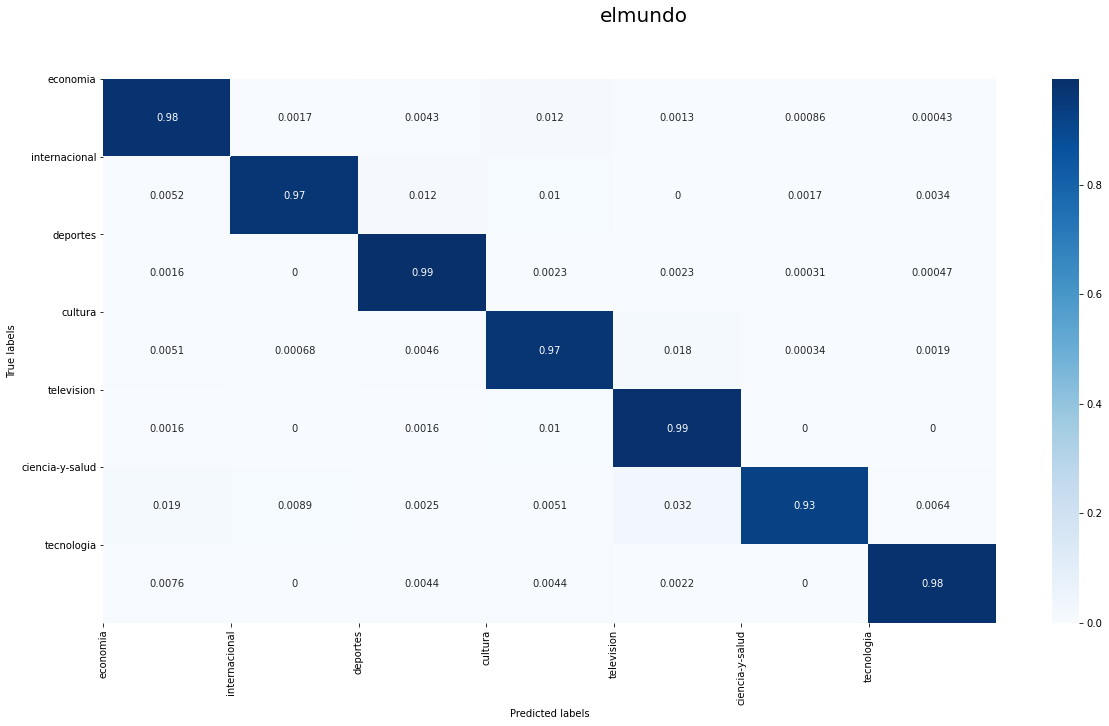

In [15]:
true_cate = [source_label[i] for i in true_labels]
pred_cate = [target_label[j] for j in pred_labels]

con_mat = confusion_matrix(true_cate,pred_cate)
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # nomalization
con_mat_norm = np.around(con_mat_norm, decimals=2)

# =====diy confusion matrix=====
matrix = [[0 for i in range(len(target_label))] for j in range(len(source_label))]
print(len(matrix),len(matrix[0]))
sums = [0 for i in range(len(source_label))]
for x,y in  zip(true_labels,pred_labels):
    matrix[x][y] += 1
    sums[x] += 1
# normalization
for i in range(len(source_label)):
    for j in range(len(target_label)):
        matrix[i][j] /= sums[i]
    
# === plot ===
fig = plt.figure(figsize=(20, 10))
sns.heatmap(matrix, annot=True, cmap='Blues')
catex = list(range(0,len(target_label),1))
catey = list(range(0,len(source_label),1))
fig.suptitle('elmundo',fontsize=20)

plt.xlabel('Predicted labels')
plt.xticks(catex,target_label)
plt.xticks(rotation=90)

plt.ylabel('True labels')
plt.yticks(catey,source_label)
plt.yticks(rotation=360)
plt.show()
# plt.savefig('./img/{}-{}-matrix.jpg'.format(init_lr,MAX_SEQ_LENGTH))